## Exploring Vectorization, Ensemble Learning, and Attention Mechanisms for Fake News Detection By Lim Wei Zhen

### Project Overview 
This project aims to develop advanced deep learning models for detecting fake news, addressing the growing challenge of misinformation on digital platforms. This study leverages feature extraction techniques like N-grams (TF-IDF) and word embeddings (GloVe). It also implements architectures such as CNNs, LSTMs, Bi-LSTMs, Bi-LSTMs with attention mechanisms, and hybrid models to enhance detection accuracy, scalability, and interpretability."

### Objectives
- **Feature Analysis:** Evaluate the impact of TF-IDF and GloVe embeddings on model performance.
- **Model Comparison:** Develop and compare various deep learning architectures tailored for fake news classification.
- **Comprehensive Evaluation:** Assess model performance using metrics such as accuracy, precision, recall, and F1-score.

### Dataset
The dataset, sourced from Kaggle ([Link](https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification)), contains 40,587 labeled news articles categorized as either fake or real. It comprises three fields: 
1. **title**: The title of the news article.
2. **text**: The content of the news article.
3. **label**: A binary classification indicating whether the news is fake (0) or true (1).

### Methodology
1. **Data Preparation**: 
    - Preprocessing: Tokenization, stopword removal, lemmatization, and other text-cleaning methods.
    - Exploratory Data Analysis (EDA): Analyzing data distributions and patterns to gain insights.
2. **Feature Engineering**:
    - TF-IDF (N-grams): Sparse matrix representation of textual data.
    - GloVe Embeddings: Dense vector representation of words to capture semantic meaning.
3. **Model Development**:  
    The following deep learning models were trained and evaluated:
    - CNN: Convolutional Neural Network for extracting spatial text features.
    - LSTM: Long Short-Term Memory Network for capturing sequential dependencies in text.
    - Bi-LSTM: Bidirectional LSTM for capturing context from both forward and backward directions.
    - CNN + LSTM: A hybrid model leveraging both spatial and sequential text features.
    - Bi-LSTM + Attention Mechanism: Enhancing focus and interpretability by allowing the model to weigh important text features.
4. **Training & Validation**:
    - Train Set: Used to train the models.
    - Validation Set: Used for hyperparameter tuning and performance validation.
5. **Hyperparameter Tuning**:
    - Optimizing regularization, dropout, units, filters, kernel size, learning rate, and optimizer using Keras Tuner's Hyperband strategy.
6. **Final Evaluation**:
    - Test Set: Models were evaluated on unseen test data to measure generalization using metrics like accuracy, precision, recall, F1-score, and by analyzing Loss vs Epoch and Accuracy vs Epoch trends.

## Libraries Used for the Project

Key libraries for data manipulation (Pandas, NumPy), visualization (Matplotlib, Seaborn), text preprocessing (NLTK, regex), feature extraction (TF-IDF, GloVe), and model development (TensorFlow, Keras Tuner) were utilized.

In [257]:
# Data Manipulation, Analysis, and Visualization
import os
import json
import pickle
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Preprocessing of Text Data
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.data import find

# Feature Extractions
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model Development
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Bidirectional, Reshape, Dropout, BatchNormalization, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping

# Hyperparameter Tuning
import keras_tuner as kt

# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Section 1 - Data Preparation

### 1.1 Load the Datasets
On Kaggle, the dataset is already divided into three splits:
- Train: 24,353 instances
- Validation: 8,117 instances
- Test: 8,117 instances

All three splits will be loaded with the following purposes:
1. Training Set: The baseline model is trained using this set.
2. Validation Set: This set is utilized during training to evaluate and fine-tune hyperparameters.
3. Test Set: This set is reserved for the final evaluation phase.

In [258]:
# Load the Dataset
train_data = pd.read_csv("train (2).csv", sep=';')
validation_data = pd.read_csv("evaluation.csv", sep=';')
test_data = pd.read_csv("test (1).csv", sep=';')

In [259]:
# Verify the Dataset Structure
print('Training Data:')
print(train_data.info())

print('\nValidation Data:')
print(validation_data.info())

print('\nTest Data:')
print(test_data.info())

Training Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24353 entries, 0 to 24352
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  24353 non-null  int64 
 1   title       24353 non-null  object
 2   text        24353 non-null  object
 3   label       24353 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 761.2+ KB
None

Validation Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8117 entries, 0 to 8116
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8117 non-null   int64 
 1   title       8117 non-null   object
 2   text        8117 non-null   object
 3   label       8117 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 253.8+ KB
None

Test Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8117 entries, 0 to 8116
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
-

In [260]:
# From `info()`, it is observed that there are an additional column called 'Unnamed: 0' in the dataset. Inspect the columns
display(train_data.head())
display(validation_data.head())
display(test_data.head())


,Unnamed: 0,title,text,label
0,0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1
1,1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1
2,2,FAIL! The Trump Organization’s Credit Score W...,While the controversy over Trump s personal ta...,0
3,3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1
4,4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0


,Unnamed: 0,title,text,label
0,0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1
1,1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1
2,2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0
3,3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0
4,4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0


,Unnamed: 0,title,text,label
0,0,"Live from New York, it's a Trump-Clinton remat...",NEW YORK (Reuters) - Veteran actor and frequen...,1
1,1,Catalan separatists to lose majority in tight ...,BARCELONA (Reuters) - Catalonia s independence...,1
2,2,North Carolina governor concedes election to D...,"WINSTON-SALEM, N.C. (Reuters) - North Carolina...",1
3,3,Draft Senate Iran legislation sets tough new U...,WASHINGTON (Reuters) - Draft legislation respo...,1
4,4,California governor taps U.S. Representative B...,"SACRAMENTO, Calif. (Reuters) - California Gove...",1


In [261]:
# By inspecting the first 5 rows of the dataset, it is observed that 'Unnamed: 0' is an index column. Drop the column.
train_data.drop('Unnamed: 0', axis=1, inplace=True)
validation_data.drop('Unnamed: 0', axis=1, inplace=True)
test_data.drop('Unnamed: 0', axis=1, inplace=True)

In [262]:
# Check the columns for the datasets after dropping the irrelevant column
print(train_data.columns)
print(validation_data.columns)
print(test_data.columns)

Index(['title', 'text', 'label'], dtype='object')
Index(['title', 'text', 'label'], dtype='object')
Index(['title', 'text', 'label'], dtype='object')


### 1.2 Descriptive Statistics
Since the datasets used in this project are fairly straightforward, we will only examine the class distribution for all three datasets and inspect whether there are any missing values.

#### 1.2.1 Class Distribution

In [263]:
# Simple function to calculate the class distribution (Counts & Percentage Total)
def class_distribution(df):
    class_counts = df['label'].value_counts()
    class_percentage = round(df['label'].value_counts(normalize=True) * 100, 2)

    class_summary = pd.DataFrame({'Count': class_counts, 'Percentage Total (%)': class_percentage})

    display(class_summary)

    return class_summary

In [264]:
# Check the class distribution for each datasets
print('Training Data:')
class_distribution(train_data)

print('\nValidation Data:')
class_distribution(validation_data)

print('\nTest Data:')
class_distribution(test_data)

Training Data:


,Count,Percentage Total (%)
label,,
1,13246,54.39
0,11107,45.61



Validation Data:


,Count,Percentage Total (%)
label,,
1,4314,53.15
0,3803,46.85



Test Data:


,Count,Percentage Total (%)
label,,
1,4364,53.76
0,3753,46.24


,Count,Percentage Total (%)
label,,
1,4364,53.76
0,3753,46.24


The class distribution indicates that all three datasets are slightly imbalanced, with class 1 being the majority. Given the minor nature of this imbalance, class balancing will not be performed at this stage unless the model's performance suggests it is necessary.

#### 1.2.2 Missing Values

In [265]:
# Check for missing values
print('Training Data:')
print(train_data.isnull().sum())

print('\nValidation Data:')
print(validation_data.isnull().sum())

print('\nTest Data:')
print(test_data.isnull().sum())

Training Data:
title    0
text     0
label    0
dtype: int64

Validation Data:
title    0
text     0
label    0
dtype: int64

Test Data:
title    0
text     0
label    0
dtype: int64


No missing values were found in any of the three datasets. Therefore, we can proceed directly to text preprocessing for the classification task.

### 1.3 Preprocessing of Text Data
To prepare the dataset for classification, the following preprocessing steps are applied to the text data:
1. **Tokenization**:  
    Splitting text into individual words.
    
2. **Remove Special Characters, Punctuation, and Stop Words**  
    Text is cleaned by removing unwanted characters and words that do not contribute to the classification task.

3. **Convert Text to Lowercase**  
    Converting all text to lowercase ensures consistency and avoids duplication caused by case differences.

4. **Lemmatization with POS Tagging**    
    Reduce words to their base or dictionary form (lemma) by considering their morphological structure, ensuring the output is a valid, normalized word. Unlike stemming, which simply removes suffixes, lemmatization produces linguistically accurate root forms.  
    Additionally, Part-of-speech (POS) tagging is performed to assign grammatical roles, further enabling accurate lemmatization and reducing words to their base forms.

References: https://www.ibm.com/think/topics/stemming-lemmatization


#### 1.3.1 Required NLTK Resources for Preprocessing of Text Data

First, download the required NLTK resources for the preprocessing of the text data. The following resources will be downloaded:
1. **`punkt`**: Punkt Tokenizer Models, a module in `nltk` designed to learn parameters from a corpus in an unsupervised way that is related to the target domain, such as a list of abbreviations, acronyms, etc.
2. **`stopwords`**: Stopwords Corpus, a corpus of common stop words (e.g., "is", "and", "the") in various languages.
3. **`averaged_perceptron_tagger`**: Averaged Perceptron Tagger, a pre-trained part-of-speech (POS) tagging model.
4. **`wordnet`**: WordNet, a lexical database of English words grouped by their meanings (synonyms, antonyms, definitions).

References: 
1. https://www.nltk.org/nltk_data/
2. https://www.askpython.com/python-modules/nltk-punkt
3. https://pythonspot.com/nltk-stop-words/
4. https://explosion.ai/blog/part-of-speech-pos-tagger-in-python
5. https://www.nltk.org/howto/wordnet.html

In [266]:
# Download the required NLTK resources for the preprocessing of text data

# Function to check and download the NLTK resources (If Not Found)
def check_and_download(resource_name, category=None):
    try:
        # Check resource location based on category
        if category:
            find(f"{category}/{resource_name}")
        else:
            find(resource_name)

        print(f"'{resource_name}' is already downloaded.")
        print()

    except LookupError:
        # Download the resource if not found
        print(f"Downloading '{resource_name}'...")

        nltk.download(resource_name)

        print(f"'{resource_name}' has been downloaded.")
        print()

# List of resources to check and download
resources = {'punkt': 'tokenizers',
             'stopwords': 'corpora',
             'averaged_perceptron_tagger': 'taggers',
             'wordnet': 'corpora',
             'punkt_tab': 'tokenizers',
             'averaged_perceptron_tagger_eng': 'taggers'}

# Check and download the resources
for resource, category in resources.items():
    check_and_download(resource, category)

'punkt' is already downloaded.

'stopwords' is already downloaded.

'averaged_perceptron_tagger' is already downloaded.

'wordnet' has been downloaded.

'punkt_tab' is already downloaded.

'averaged_perceptron_tagger_eng' is already downloaded.



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\WeiZhenLim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### 1.3.2 Text Data Preprocessing Pipeline

To streamline and standardize the text data preprocessing across all pre-split datasets (training set: `train_data`, validation set: `evaluation_data`, and test set: `test_data`),a `Pipeline` from `sklearn` is implemented. The pipeline ensures consistency and efficiency in applying the following steps:
1. Tokenizing text into individual words.
2. Removing special characters, punctuation, and stop words.
3. Converting text to lowercase for uniformity.
4. Applying POS tagging for accurate lemmatization.

By using a `Pipeline`, the preprocessing steps are modular, reusable, and maintainable, enabling seamless application to all datasets.

References:
1. https://www.ibm.com/think/topics/stemming-lemmatization
2. https://regex101.com/

In [267]:
# Initialize NLTK Tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [268]:
# Helper Function to map LTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Custom transformer for text preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self.preprocess_text(text) for text in X]).reshape(-1, 1)
    
    def get_feature_names_out(self, input_features=None):
        return ['preprocessed']
    
    def preprocess_text(self, text):
        # Tokenize text into individual words
        tokens = word_tokenize(text)

        # Remove special characters and punctuation
        """
        Explanation for Regular Expression:
        [^...] = NOT ONE of the character
        \w = ANY ONE word/non-word character (equivalent to [a-zA-Z0-9_])
        \s = ANY ONE space/non-space character (equivalent to [ \n\r\t\f])
        """
        tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

        # Filter out empty tokens after removing special characters and punctuation
        tokens = [token for token in tokens if token]
        
        # Convert to lowercase
        tokens = [token.lower() for token in tokens]

        # Remove stopwords
        tokens = [token for token in tokens if token not in stop_words]

        # POS Tagging and Lemmatization
        pos_tags = pos_tag(tokens)
        tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos_tag)) for token, pos_tag in pos_tags]

        # Reconstruct processed text
        return ' '.join(tokens)

In [269]:
# Create pipeline
text_pipeline = Pipeline([
    ('text_preprocessor', TextPreprocessor())
])

# Create the preprocessing pipeline using ColumnTransformer
preprocessing_pipeline = ColumnTransformer([
    ('title', text_pipeline, 'title'),
    ('text', text_pipeline, 'text')
], remainder='passthrough')

In [270]:
# Function that converts preprocessing output to DataFrame
def pipeline_to_df(X_prep, pipeline, X_ori):

    # Convert the output to DataFrame
    data = pd.DataFrame(X_prep, columns=pipeline.get_feature_names_out(), index=X_ori.index)

    # Remove the 'remainder__' from the 'label' column
    data.columns = data.columns.str.replace('remainder__', '')

    # Cast the 'label' column to integer
    data['label'] = data['label'].astype('int64')

    return data

The following function check for existing preprocessed files, load them if they exist, or preprocess the data if they don't.

In [271]:
# Function to save data as .npy
def save_npy(data, filename):
    np.save(filename, data)

# Function to load data as .npy
def load_npy(filename):
    return np.load(filename, allow_pickle=True)

# Function to save data as .pkl
def save_pkl(data, filename):
    data.to_pickle(filename)

# Function to load data as .pkl
def load_pkl(filename):
    return pd.read_pickle(filename)


In [272]:
# File paths for saved preprocessed data
train_file = "train_data_preprocessed.pkl"
validation_file = "validation_data_preprocessed.pkl"
test_file = "test_data_preprocessed.pkl"

In [273]:
# Check and process the training data
if os.path.exists(train_file):
    print("Loading preprocessed training data...")
    train_data_preprocessed = load_pkl(train_file)
else:
    print("Preprocessing training data...")
    train_data_preprocessed = preprocessing_pipeline.fit_transform(train_data)
    train_data_preprocessed = pipeline_to_df(train_data_preprocessed, preprocessing_pipeline, train_data)
    save_pkl(train_data_preprocessed, train_file)

# Check and process the validation data
if os.path.exists(validation_file):
    print("Loading preprocessed validation data...")
    validation_data_preprocessed = load_pkl(validation_file)
else:
    print("Preprocessing validation data...")
    validation_data_preprocessed = preprocessing_pipeline.fit_transform(validation_data)
    validation_data_preprocessed = pipeline_to_df(validation_data_preprocessed, preprocessing_pipeline, validation_data)
    save_pkl(validation_data_preprocessed, validation_file)

# Check and process the test data
if os.path.exists(test_file):
    print("Loading preprocessed test data...")
    test_data_preprocessed = load_pkl(test_file)
else:
    print("Preprocessing test data...")
    test_data_preprocessed = preprocessing_pipeline.fit_transform(test_data)
    test_data_preprocessed = pipeline_to_df(test_data_preprocessed, preprocessing_pipeline, test_data)
    save_pkl(test_data_preprocessed, test_file)

Loading preprocessed training data...
Loading preprocessed validation data...
Loading preprocessed test data...


In [274]:
train_data.shape

(24353, 3)

In [275]:
display(train_data_preprocessed.head())

,title__preprocessed,text__preprocessed,label
0,palestinian switch christmas light bethlehem a...,ramallah west bank reuters palestinian switch ...,1
1,china say trump call taiwan president wo nt ch...,beijing reuters u presidentelect donald trump ...,1
2,fail trump organization credit score make laugh,controversy trump personal tax return continue...,0
3,zimbabwe military chief china trip normal visi...,beijing reuters trip beijing last week zimbabw...,1
4,uncourageous president ever receive courage aw...,never uncourageous person white house barack o...,0


In [276]:
train_data_preprocessed.shape

(24353, 3)

Due to time and resource limitation, both `title` and `text` fields are combined.

In [277]:
# Combine the preprocessed `title` and `text` fields into a single `content` field
train_data_preprocessed['content'] = train_data_preprocessed['title__preprocessed'] + ' ' + train_data_preprocessed['text__preprocessed']
validation_data_preprocessed['content'] = validation_data_preprocessed['title__preprocessed'] + ' ' + validation_data_preprocessed['text__preprocessed']
test_data_preprocessed['content'] = test_data_preprocessed['title__preprocessed'] + ' ' + test_data_preprocessed['text__preprocessed']

### 1.4 Exploratory Data Analysis (EDA)

In this section, we explore the dataset to gain insights into its structure and characteristics before applying deep learning models. The following analyses are conducted:

1. **Class Distribution Analysis:**  
    Assess the distribution of the `label` field (0 for fake news, 1 for true news) to evaluate the balance of the dataset.

2. **Word Frequency Distributions:**  
    Analyze the overall word frequency distributions to understand commonly used terms in the preprocessed dataset.

3. **Dataset Characteristics Visualization:**  
    Visualize key dataset characteristics, including:
    - The most frequent words in the preprocessed dataset, with a detailed breakdown by `label` (0 for fake news, 1 for true news).
    - The average length of text fields.

For analysis and visualization purposes, the training data is preprocessed using the `preprocessing_pipeline` created in the previous section. These insights will guide subsequent steps in model development and evaluation.

In [278]:
# Create a copy for EDA
EDA_data = train_data_preprocessed.copy()

#### 1.4.1 Class Distribution Analysis

The distribution of the `label` field (0 for fake news, 1 for true news) is analyzed to evaluate the dataset's balance. This step helps identify potential biases that may influence model performance and guide data preprocessing strategies.

,Count,Percentage Total (%)
label,,
1,13246,54.39
0,11107,45.61


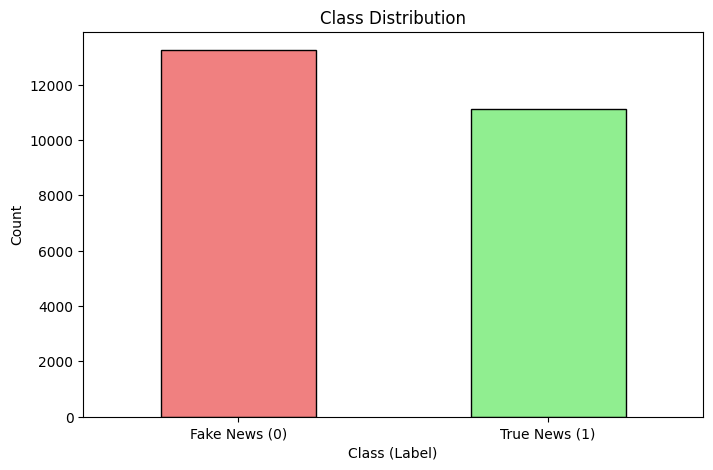

In [279]:
# Get the class distribution of the preprocessed training set
class_summary = class_distribution(EDA_data)

# Plot class distribution for the training set
plt.figure(figsize=(8, 5))
class_summary['Count'].plot(kind='bar', color=['lightcoral', 'lightgreen'], edgecolor='black')
plt.title('Class Distribution')
plt.xlabel('Class (Label)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Fake News (0)', 'True News (1)'], rotation=0)
plt.show()

#### 1.4.2 Word Frequency Distributions

In this section, we analyze the overall distribution of words in the `content` field in the training set. This analysis helps identify words commonly used terms and their frequency in the preprocessed training set.

In [280]:
# Function to plot word frequency distributions (bar chart and word cloud)
def plot_word_freq(data, column, label_value = None, top_n = 10):

    # Filter data based on label value
    if label_value is not None:
        data = data[data['label'] == label_value]

    # Graph title based on label value
    if label_value == 1:
        grp_title = '(True News)'
    elif label_value == 0:
        grp_title = '(Fake News)'
    else:
        grp_title = '(Overall)'

    # Combine all rows in the column into a single string
    all_words = ' '.join(data[column].dropna()).split()

    # Calculate the word frequency
    word_freq = Counter(all_words)

    # Plot the top N words as bar chart
    most_common_words = word_freq.most_common(top_n)
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue', edgecolor='black')
    plt.title(f"Top {top_n} Words in '{column}' {grp_title}")
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

    # Plot the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for '{column}' {grp_title}")
    plt.axis('off')
    plt.show()

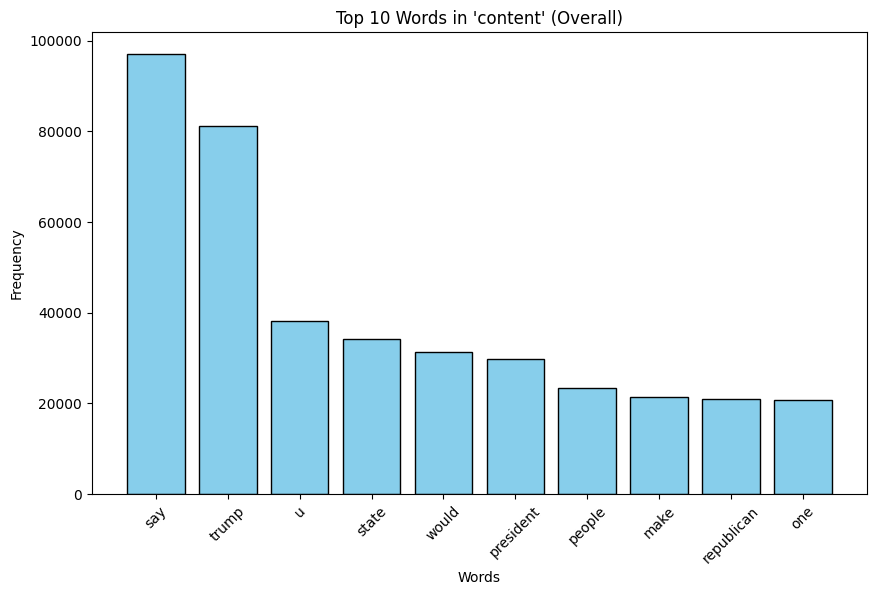

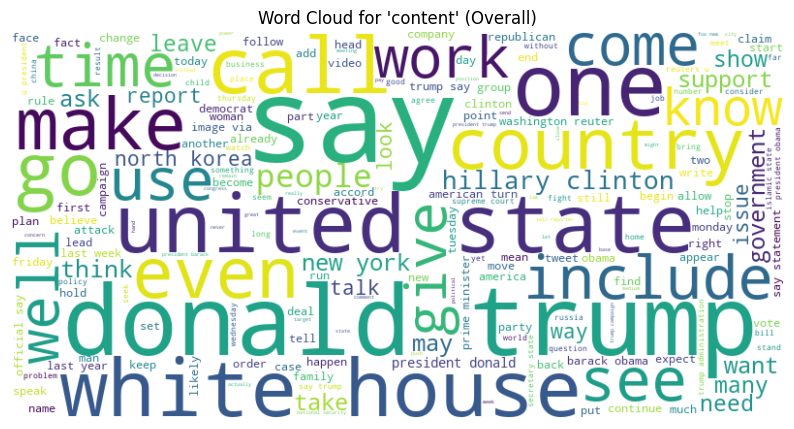

In [281]:
plot_word_freq(EDA_data, 'content')

#### 1.4.3 Most Frequent Words by `label`

In this section, we analyze the most frequent words in the `content` field, grouped by the label field (0 for fake news, 1 for true news).

Most Frequent Words in `content` for Fake News (`label` = 0)

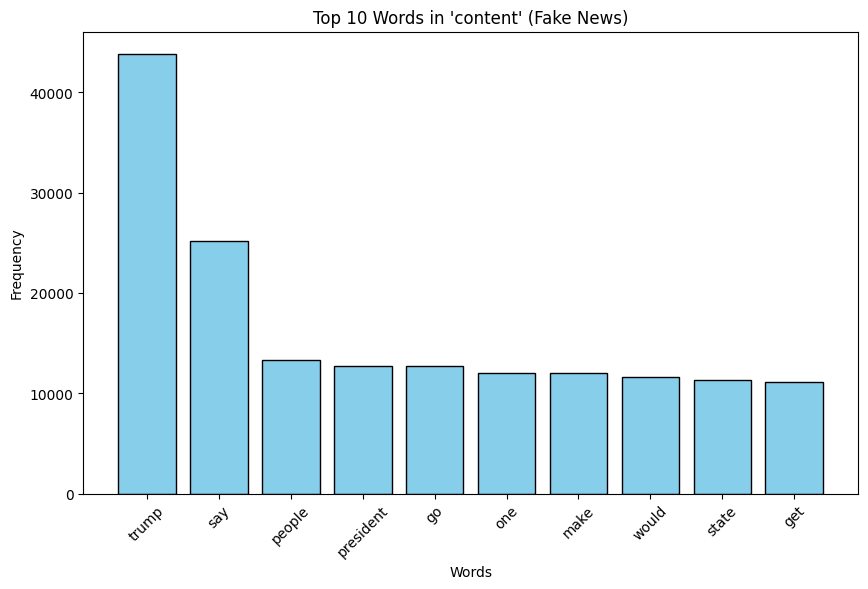

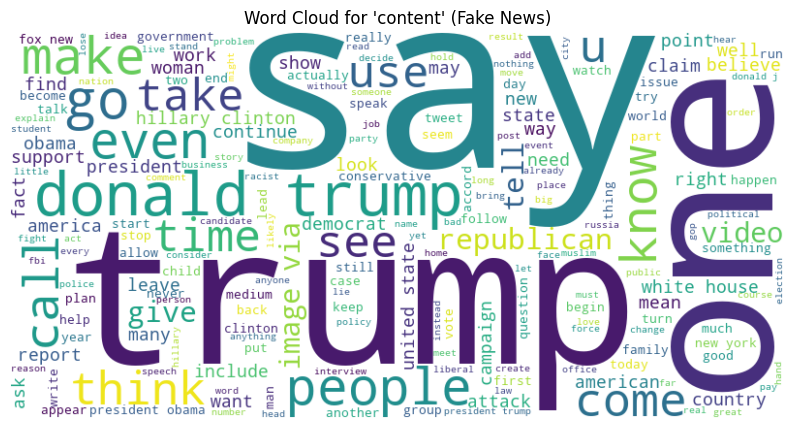

In [282]:
plot_word_freq(EDA_data, 'content', label_value=0)

Most Frequent Words in `content` for True News (`label` = 1)

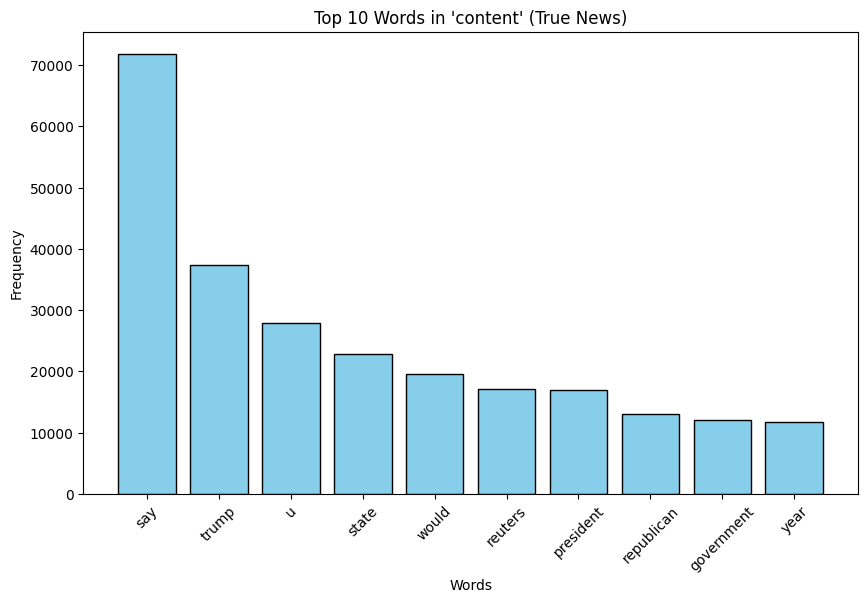

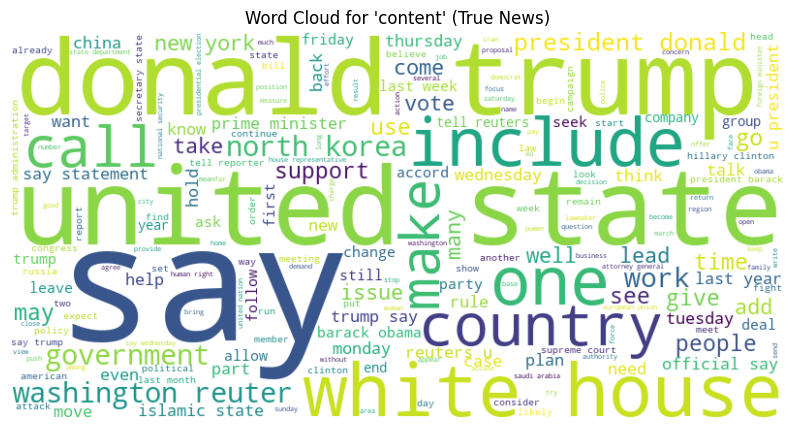

In [283]:
plot_word_freq(EDA_data, 'content', label_value=1)

#### 1.4.4 Average Text Length

To identify potential linguistic differences between fake and true news, we calculate the average length of the `content` fields, grouped by `label`.

In [284]:
# Function that calculates the average length of text
def calculate_average_lengths(df, column):
    """
    Calculate overall average length, average length for label=0, and label=1.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column (str): The column name to analyze.

    Returns:
        None
    """
    # Calculate overall average length
    overall_avg = df[column].str.split().str.len().mean()

    # Calculate average length for each label
    avg_by_label = df.groupby('label')[column].apply(lambda x: x.str.split().str.len().mean())

    # Display results
    print(f"Overall Average Length of '{column}': {overall_avg:.2f} words")
    print(f"Average Length of '{column}' for Label 0 (Fake News): {avg_by_label[0]:.2f} words")
    print(f"Average Length of '{column}' for Label 1 (True News): {avg_by_label[1]:.2f} words")

In [285]:
calculate_average_lengths(EDA_data, 'content')

Overall Average Length of 'content': 246.38 words
Average Length of 'content' for Label 0 (Fake News): 250.82 words
Average Length of 'content' for Label 1 (True News): 242.65 words


## Section 2 - Feature Engineering

### 2.1 Feature and Target Extraction

All three pre-split datasets (train, validation, test) were divided into features (context) and target labels (fake or real).

In [286]:
# Split all three pre-split datasets into features and target
X_train = train_data_preprocessed[['content']]
y_train = train_data_preprocessed['label'].values

X_val = validation_data_preprocessed[['content']]
y_val = validation_data_preprocessed['label'].values

X_test = test_data_preprocessed[['content']]
y_test = test_data_preprocessed['label'].values

### 2.2 N-grams (TF-IDF)

In this section, we extract unigrams and bigrams from the `content` fields using TF-IDF vectorization. This technique captures statistical relationships in the dataset, highlighting the importance of terms and phrases for distinguishing between fake and true news. The text preprocessing pipeline is integrated with TF-IDF to streamline and standardize feature extraction across the dataset.

In [287]:
# Initialize TF-IDF Vectorizers
tfidf_vectorizer  = TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')

In [288]:
# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['content'])

# Transform validation and test data
X_val_tfidf = tfidf_vectorizer.transform(X_val['content'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['content'])

In [289]:
print("TFIDF Vectorized Training Data:")
print(X_train_tfidf.shape)

print("\nTFIDF Vectorized Validation Data:")
print(X_val_tfidf.shape)

print("\nTFIDF Vectorized Test Data:")
print(X_test_tfidf.shape)

TFIDF Vectorized Training Data:
(24353, 5000)

TFIDF Vectorized Validation Data:
(8117, 5000)

TFIDF Vectorized Test Data:
(8117, 5000)


### 2.2 Word Embeddings with GloVe

In this section, we implement word embedding on the `content` field, which is a combination of the `title` and `text` fields. By merging these two fields, the model processes the combined textual data using pre-trained GloVe embeddings. This approach ensures the model captures both the brevity and relevance of the title and the contextual depth of the text in a unified representation. The combined embeddings are then used to train the model for final predictions.

Reference: https://nlp.stanford.edu/projects/glove/

#### 2.2.1 Load GloVe Embeddings

In [290]:
# Function to load GloVe embeddings
def load_glove_embeddings(file_path, embedding_dim):

    embeddings_index = {}

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefficients = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefficients

    print(f"Loaded {len(embeddings_index)} word vectors.")

    return embeddings_index

embedding_dim = 300
glove_embeddings = load_glove_embeddings('glove.6B.300d.txt', embedding_dim)

Loaded 400000 word vectors.


#### 2.2.2 Prepare Tokenizer and Padded Sequences

In this step, `content` is tokenized and converted into padded sequences to ensure uniform input lengths for deep learning models. Tokenization transforms text into sequences of integers representing word indices, while padding adjusts the sequence lengths to a predefined maximum.

In [291]:
# Function to tokenize the Text Data
def prepare_text_data(fit_data, trans_data, vocab_size=20000, max_seq_length=300):

    # Fit Tokenizer on the training set
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(fit_data)

    # Transform training, validation, and test sets into sequences
    sequences = tokenizer.texts_to_sequences(trans_data)

    # Pad sequences to ensure consistent input size
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return padded_sequences, tokenizer.word_index


In [292]:
# Tokenize and pad the 'content' data
X_train_padded, word_index = prepare_text_data(X_train['content'], X_train['content'])
X_val_padded, _ = prepare_text_data(X_train['content'], X_val['content']) 
X_test_padded, _ = prepare_text_data(X_train['content'], X_test['content'])

In [293]:
# Output shapes
print("Training set shape:", X_train_padded.shape)
print("Validation set shape:", X_val_padded.shape)
print("Test set shape:", X_test_padded.shape)

Training set shape: (24353, 300)
Validation set shape: (8117, 300)
Test set shape: (8117, 300)


#### 2.2.3 Create Embedding Matrix

Map each word in the dataset’s vocabulary to its corresponding GloVe vector. Words not found in the GloVe file will have zero vectors.

In [294]:
# Function to create embedding matrix
def create_embedding_matrix(glove_embeddings, word_index, embedding_dim):

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

    for word, i in word_index.items():

        embedding_vector = glove_embeddings.get(word)

        if embedding_vector is not None:

            embedding_matrix[i] = embedding_vector

    print(f"Embedding matrix shape: {embedding_matrix.shape}")
    
    return embedding_matrix

In [295]:
embedding_matrix = create_embedding_matrix(glove_embeddings, word_index, embedding_dim)

Embedding matrix shape: (160075, 300)


## Section 3: Model Development and Training

In this section, several deep learning models were developed and trained to classify fake news. Each model was designed to work with two feature extraction techniques: TF-IDF and GloVe embeddings. The methodology for model development and training involved defining model architectures, compiling and training the models, and evaluating their performance on validation data.

1. **Model Architectures**:  
The following model architectures were implemented:
   - CNN: Extracts spatial text features using convolutional layers followed by pooling and dense layers.
   - LSTM: Captures sequential dependencies in text with stacked LSTM layers.
   - Bi-LSTM: Leverages bidirectional LSTMs to capture context from both forward and backward directions.
   - CNN + LSTM Hybrid: Combines convolutional feature extraction with sequential modeling using LSTM layers.
   - Bi-LSTM with Attention Mechanism: Enhances interpretability by assigning weights to key text features through an attention layer.

2. **Training and Validation**:
   - Feature Types: Models were trained using TF-IDF features (reshaped into sequences) and pre-trained GloVe embeddings (as fixed embedding layers).
   - Training Process: Each model was compiled using the Adam optimizer and trained with early stopping to prevent overfitting. Training was monitored using metrics such as accuracy, precision, and recall.
   - Validation Set: Used to tune hyperparameters and validate model performance during training.

3. **Performance Analysis**:
   - Evaluation Metrics: Each model was evaluated on accuracy, precision, recall, and F1-score.
   - Training Visualization: Training progress was visualized through Loss vs. Epoch and Accuracy vs. Epoch plots for each model.
   - Model Comparison: Metrics and performance plots were compiled into a summary table, highlighting the best-performing models for each feature extraction method.

4. **Top-Performing Model Selection**:
   - The top-performing models (Top 5) will be selected based on performance analysis and used for hyperparameter tuning.

References:
1. https://keras.io/api/layers/attention_layers/attention/
2. https://analyticsindiamag.com/deep-tech/a-beginners-guide-to-using-attention-layer-in-neural-networks/
3. https://www.geeksforgeeks.org/adding-attention-layer-to-a-bi-lstm/#adding-attention-layer-to-a-bilstm-stepbystep
4. https://www.aionlinecourse.com/blog/how-to-add-attention-layer-to-a-bi-lstm

#### Functions for Model Building, Compilation, Training, Evaluation, and Visualization

In [296]:
# Build Model Function
def build_model(model_type, feature_type, input_shapes, chunk_size=50, word_index=None, embedding_matrices=None):

    # Define input layer by feature
    if feature_type == 'glove':  # GloVe embedding

        glove_input = Input(shape=(input_shapes,), name='embedding_layer')

        # Embedding layer with pre-trained GloVe weight
        embedding_layer = Embedding(
            input_dim=len(word_index) + 1,
            output_dim=embedding_matrices.shape[1],
            input_length=input_shapes,
            weights=[embedding_matrices],
            trainable=False
        )(glove_input)

        # Assign embedding_layer to a variable
        processed_layer  = embedding_layer
    
    elif feature_type == 'tfidf':
        
        # Reshape TF-IDF to (batch size, timesteps, features)
        tfidf_input = Input(shape=(input_shapes,), name='tfidf_layer')
        reshaped_layer = Reshape((input_shapes // chunk_size, chunk_size))(tfidf_input)

        # Assign reshaped_layer to a variable
        processed_layer  = reshaped_layer

    else:
        raise ValueError("Invalid feature_type specified!")


    # Define model architecture by model_type
    if model_type == 'cnn': 

        # CNN Layers
        layer = Conv1D(128, kernel_size=3, activation='relu')(processed_layer)
        layer = BatchNormalization()(layer)
        layer = GlobalMaxPooling1D()(layer)
        layer = Dropout(0.4)(layer)

        # Fully Connected Layers
        final_layer = Dense(128, activation='relu')(layer)
        final_layer = BatchNormalization()(final_layer)
        final_layer = Dropout(0.4)(final_layer)

    elif model_type == 'lstm': 

        # First LSTM Layer 
        layer = LSTM(128, return_sequences=True)(processed_layer)
        layer = Dropout(0.4)(layer)

        # Second LSTM Layer
        layer = LSTM(64, return_sequences=False)(layer) 
        layer = Dropout(0.4)(layer)

        # Fully connected layer
        final_layer = Dense(64, activation='relu')(layer)
        final_layer = BatchNormalization()(final_layer)
        final_layer = Dropout(0.4)(final_layer)

    elif model_type == 'bilstm':

        # First LSTM Layer 
        layer = Bidirectional(LSTM(128, return_sequences=True))(processed_layer)
        layer = Dropout(0.4)(layer)

        # Second LSTM Layer
        layer = Bidirectional(LSTM(64, return_sequences=False))(layer) 
        layer = Dropout(0.4)(layer)

        # Fully connected layer
        final_layer = Dense(64, activation='relu')(layer)
        final_layer = BatchNormalization()(final_layer)
        final_layer = Dropout(0.4)(final_layer)

    elif model_type == 'cnn_lstm':

        # CNN Layers
        cnn_layer = Conv1D(128, kernel_size=3, activation='relu')(processed_layer)
        cnn_layer = BatchNormalization()(cnn_layer)
        cnn_layer = GlobalMaxPooling1D()(cnn_layer)
        cnn_layer = Dropout(0.4)(cnn_layer)

        # Expand dimensions to match LSTM input
        lstm_input = Reshape((1, -1))(cnn_layer)

        # LSTM Layer
        lstm_layer = LSTM(128, return_sequences=False)(lstm_input)
        lstm_layer = Dropout(0.4)(lstm_layer)

        # Fully connected layer
        final_layer = Dense(64, activation='relu')(lstm_layer)
        final_layer = BatchNormalization()(final_layer)
        final_layer = Dropout(0.4)(final_layer)

    elif model_type == 'bilstm_attention':
        
        # Bi-LSTM Layer
        bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(processed_layer)
        bilstm_layer = Dropout(0.4)(bilstm_layer)

        # Attention Layer
        query = Dense(256)(bilstm_layer)
        attention_output = Attention()([query, bilstm_layer])

        # Pooling layer to reduce sequence dimension
        pooled_output = GlobalMaxPooling1D()(attention_output)

        # Fully connected layer
        final_layer = Dense(64, activation='relu')(pooled_output)
        final_layer = BatchNormalization()(final_layer)
        final_layer = Dropout(0.4)(final_layer)

    else:
        raise ValueError("Invalid model_type specified!")

    output = Dense(1, activation='sigmoid')(final_layer)

    return Model(inputs=glove_input if feature_type == 'glove' else tfidf_input, outputs=output)


In [297]:
# Compile and Train Function
def compile_and_train(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=64):

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                   patience=3,          # Stop training if no improvement for 3 consecutive epochs
                                   restore_best_weights=True  # Restore the model weights from the best epoch
                                   )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],  
        verbose=1
    )
        
    return history

In [298]:
# Evaluate Model Function
def evaluate_model(model, X_test, y_test):
    
    y_pred = model.predict(X_test)

    y_pred = (y_pred > 0.5).astype(int)

    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }

In [299]:
# Function to save model and history
def save_model_and_history(model, history, model_name, save_dir="models"):
    os.makedirs(save_dir, exist_ok=True)

    # Save the model
    model_path = os.path.join(save_dir, f"{model_name}.keras")
    model.save(model_path)
    print(f"Model saved to {model_path}")
    
    # Save the training history
    history_path = os.path.join(save_dir, f"{model_name}_history.json")
    with open(history_path, "w") as f:
        json.dump(history.history, f)
    print(f"History saved to {history_path}")

# Function to load model and history
def load_model_and_history(model_name, save_dir="models"):
    # Load the model
    model_path = os.path.join(save_dir, f"{model_name}.keras")
    history_path = os.path.join(save_dir, f"{model_name}_history.json")
    
    if os.path.exists(model_path) and os.path.exists(history_path):
        model = load_model(model_path)
        print(f"Model loaded from {model_path}")
        
        with open(history_path, "r") as f:
            history = json.load(f)
        print(f"History loaded from {history_path}")
        
        return model, history
    else:
        return None, None

# Function to check and train/load model
def get_or_train_model(build_func, model_type, feature_type, input_shapes, X_train, y_train, X_val, y_val, model_name, save_dir="models", word_index=None, embedding_matrices=None):
    # Try to load the model and history
    model, history = load_model_and_history(model_name, save_dir)
    
    if model is not None and history is not None:
        print(f"Model and history for '{model_name}' loaded successfully.")
    else:
        print(f"No saved model found for '{model_name}'. Training the model...")
        model = build_func(model_type, feature_type, input_shapes, word_index=word_index, embedding_matrices=embedding_matrices)
        history = compile_and_train(model, X_train, y_train, X_val, y_val)
        save_model_and_history(model, history, model_name, save_dir)
    
    return model, history

In [300]:
# Function to plot Training Loss vs. Validation Loss and Training Accuracy vs. Validation Accuracy
def plot_model_performance(history, model_name, split_title=False):

    try:
        # Access history data
        if isinstance(history, dict):
            history = history
        else:
            history = history.history

        # Modify title
        if split_title:
            loss_title = f'{model_name}: \nLoss vs. Epochs'
            acc_title = f'{model_name}: \nAccuracy vs. Epochs'
        else:
            loss_title = f'{model_name}: Loss vs. Epochs'
            acc_title = f'{model_name}: Accuracy vs. Epochs'

        # Plot Loss
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title(loss_title)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history['accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title(acc_title)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"An error occurred: {e}")

#### 3.1 CNN with TF-IDF

In [301]:
print("CNN with TF-IDF...")

cnn_tfidf, cnn_tfidf_history = get_or_train_model(
    build_model,
    'cnn', 'tfidf',
    X_train_tfidf.shape[1],
    X_train_tfidf, y_train,             
    X_val_tfidf, y_val,
    model_name="cnn_tfidf"
)

CNN with TF-IDF...
Model loaded from models\cnn_tfidf.keras
History loaded from models\cnn_tfidf_history.json
Model and history for 'cnn_tfidf' loaded successfully.


Model architecture

In [302]:
cnn_tfidf.summary()

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tfidf_layer (InputLayer)        │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_23 (Reshape)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 98, 128)        │        19,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 98, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_22         │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,957 (429.52 KB)

 Trainable params: 36,481 (142.50 KB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 72,964 (285.02 KB)

Evaluate the model on validation set

In [303]:
cnn_tfidf_metrics = evaluate_model(cnn_tfidf, X_val_tfidf, y_val)
print("CNN with TF-IDF Performance:")
print(cnn_tfidf_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN with TF-IDF Performance:
{'accuracy': 0.8017740544536158, 'precision': 0.8345288152362107, 'recall': 0.7821047751506722, 'f1_score': 0.8074667943041761}


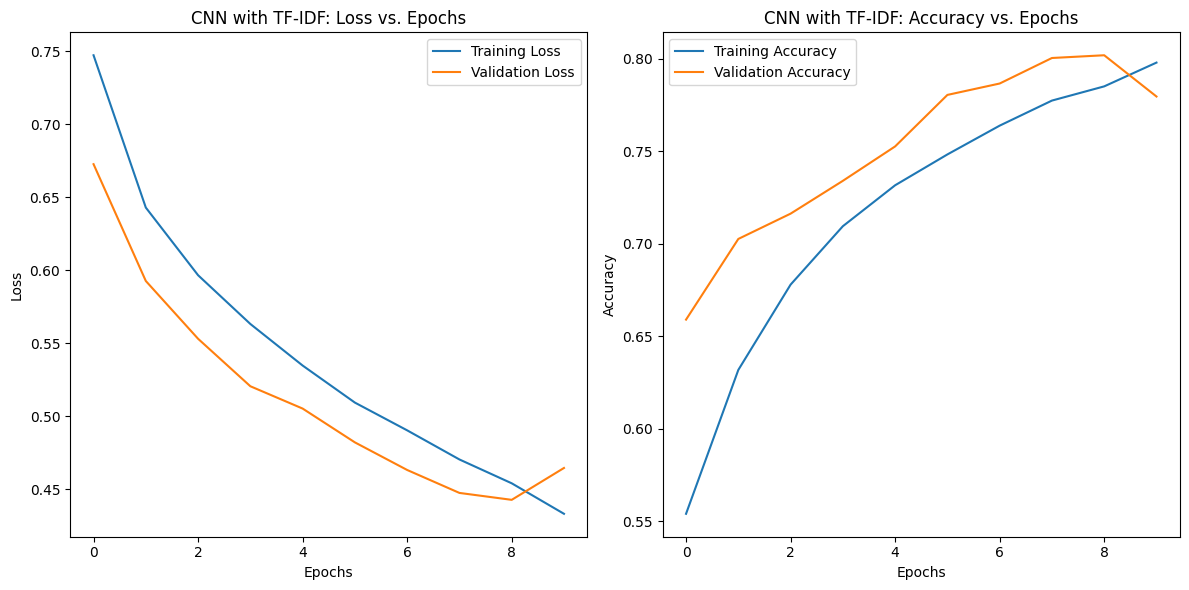

In [304]:
plot_model_performance(cnn_tfidf_history, "CNN with TF-IDF")

**Loss vs. Epochs**:
- Trend: Both training and validation loss decrease steadily over epochs, indicating effective learning.
- Convergence: Training loss continues to decrease, while validation loss plateaus and slightly increases toward the end, suggesting minor overfitting.

**Accuracy vs. Epochs**:
- Trend: Both training and validation accuracy improve consistently across epochs, with validation accuracy slightly higher than training accuracy.
- Convergence: The curves are closely aligned, indicating good generalization.

**Summary**:  
The model exhibits a stable decrease in loss and improvement in accuracy. Although there is slight overfitting, the validation accuracy is strong, and the trends suggest effective learning and generalization.

In [305]:
ccn_tfidf_plot_rating = 'Good'

#### 3.2 CNN with GloVe Embeddings

In [306]:
print("CNN with GloVe Embeddings...")

cnn_glove, cnn_glove_history = get_or_train_model(
    build_model,
    'cnn', 'glove',
    X_train_padded.shape[1],
    X_train_padded, y_train,
    X_val_padded, y_val,
    model_name="cnn_glove",
    word_index=word_index,
    embedding_matrices=embedding_matrix
)

CNN with GloVe Embeddings...
Model loaded from models\cnn_glove.keras
History loaded from models\cnn_glove_history.json
Model and history for 'cnn_glove' loaded successfully.


Model architecture

In [307]:
cnn_glove.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (InputLayer)    │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_17 (Embedding)        │ (None, 300, 300)       │    48,022,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 298, 128)       │       115,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 298, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_23         │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,420,457 (184.71 MB)

 Trainable params: 132,481 (517.50 KB)

 Non-trainable params: 48,023,012 (183.19 MB)

 Optimizer params: 264,964 (1.01 MB)

Evaluate the model on validation set

In [308]:
cnn_glove_metrics = evaluate_model(cnn_glove, X_val_padded, y_val)
print("CNN with GloVe Embeddings Performance:")
print(cnn_glove_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
CNN with GloVe Embeddings Performance:
{'accuracy': 0.9706788222249599, 'precision': 0.9822527212494084, 'recall': 0.9622160407974037, 'f1_score': 0.9721311475409836}


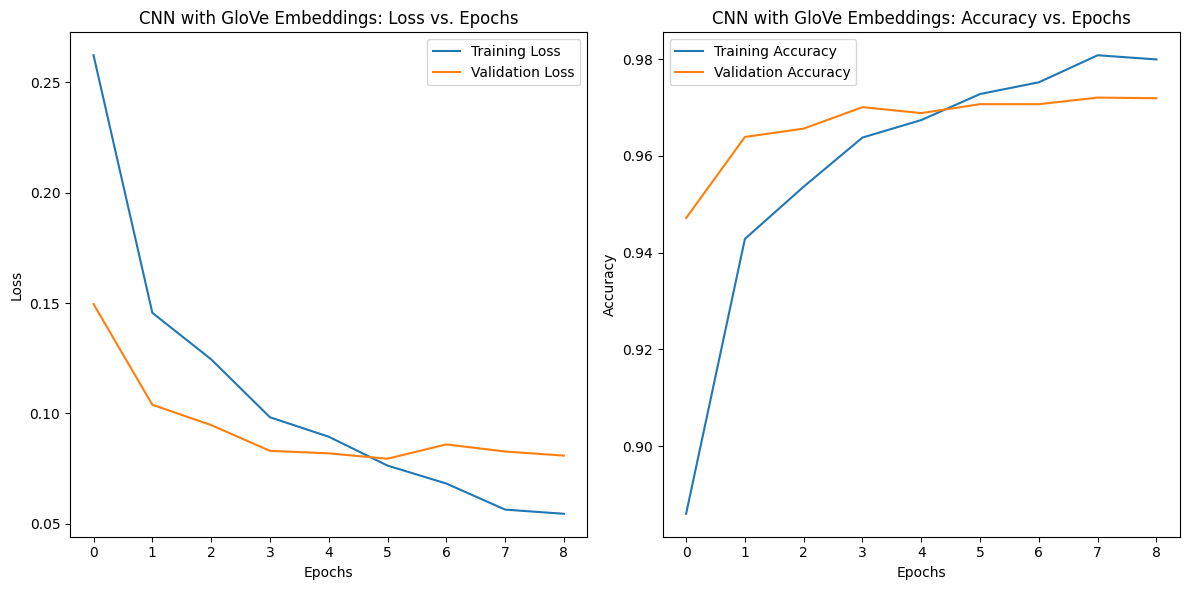

In [309]:
plot_model_performance(cnn_glove_history, "CNN with GloVe Embeddings")

**Loss vs. Epochs**:
- Trend: Both training and validation loss decrease steadily, with the validation loss plateauing at a low level toward the end.
- Convergence: There is no significant gap between training and validation loss, indicating good generalization.

**Accuracy vs. Epochs**:
- Trend: Training and validation accuracy improve steadily and converge toward high accuracy values (>0.96).
- Convergence: The validation accuracy remains close to training accuracy, demonstrating minimal overfitting and excellent model performance.

**Summary**:  
The graphs show smooth convergence with high accuracy and low loss for both training and validation sets. This indicates excellent generalization and model performance, making this one of the best results.

In [310]:
cnn_glove_plot_rating = 'Very Good'

#### 3.3 LSTM with TF-IDF

In [311]:
print("LSTM with TF-IDF...")

lstm_tfidf, lstm_tfidf_history = get_or_train_model(
    build_model,
    'lstm', 'tfidf',
    X_train_tfidf.shape[1],
    X_train_tfidf, y_train,
    X_val_tfidf, y_val,
    model_name="lstm_tfidf"
) 

LSTM with TF-IDF...
Model loaded from models\lstm_tfidf.keras
History loaded from models\lstm_tfidf_history.json
Model and history for 'lstm_tfidf' loaded successfully.


Model architecture

In [312]:
lstm_tfidf.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tfidf_layer (InputLayer)        │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_24 (Reshape)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 100, 128)       │        91,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 436,357 (1.66 MB)

 Trainable params: 145,409 (568.00 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 290,820 (1.11 MB)

Evaluate the model on validation set

In [313]:
lstm_tfidf_metrics = evaluate_model(lstm_tfidf, X_val_tfidf, y_val)
print("LSTM with TF-IDF Performance:")
print(lstm_tfidf_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
LSTM with TF-IDF Performance:
{'accuracy': 0.9317481828261673, 'precision': 0.9563106796116505, 'recall': 0.9133055169216504, 'f1_score': 0.9343134930045056}


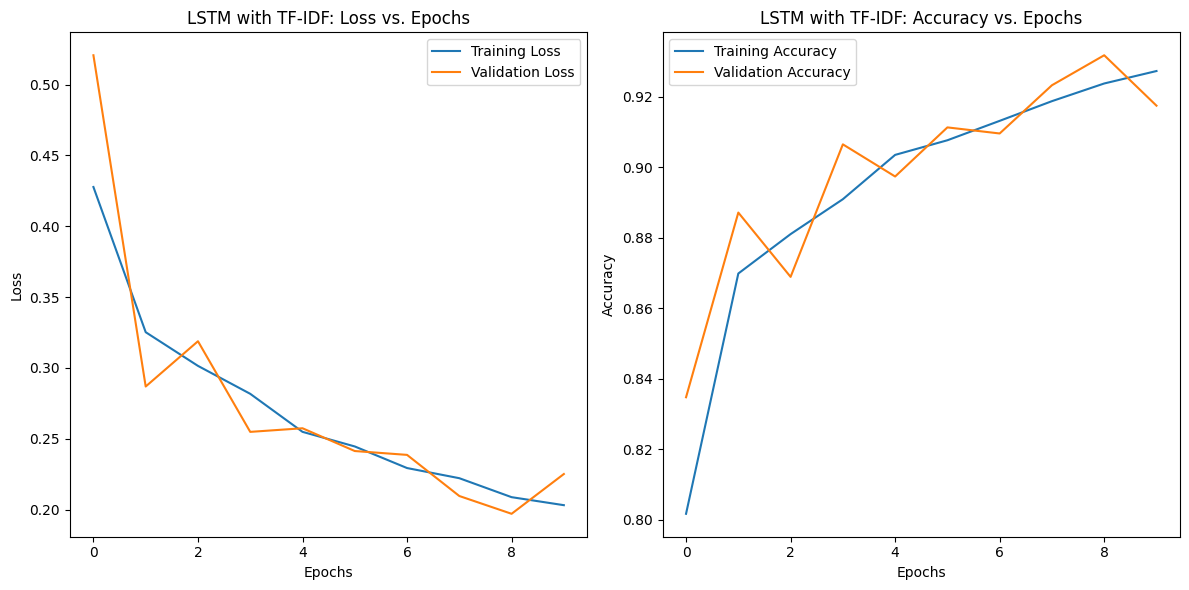

In [314]:
plot_model_performance(lstm_tfidf_history, "LSTM with TF-IDF")

**Loss vs. Epochs**:
- Trend: Both training and validation loss decrease steadily with good alignment, indicating effective learning and minimal overfitting.
- Convergence: The validation loss remains closely aligned with the training loss, with no significant divergence.

**Accuracy vs. Epochs**:
- Trend: Training and validation accuracy improve steadily, with some minor fluctuations in the validation accuracy curve.
- Convergence: The overall trends are consistent, but the fluctuations in validation accuracy suggest slight instability during training.

**Summary**:  
The graphs show steady improvement in performance, with closely aligned training and validation curves. Minor fluctuations in validation accuracy prevent it from being rated "Very Good."

In [315]:
lstm_tfidf_plot_rating = 'Good'

#### 3.4 LSTM with GloVe Embeddings

In [316]:
print("LSTM with GloVe Embeddings...")

lstm_glove, lstm_glove_history = get_or_train_model(
    build_model,
    'lstm', 'glove',
    X_train_padded.shape[1],
    X_train_padded, y_train,
    X_val_padded, y_val,
    model_name="lstm_glove",
    word_index=word_index,
    embedding_matrices=embedding_matrix
)

LSTM with GloVe Embeddings...
Model loaded from models\lstm_glove.keras
History loaded from models\lstm_glove_history.json
Model and history for 'lstm_glove' loaded successfully.


Model architecture

In [317]:
lstm_glove.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (InputLayer)    │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_18 (Embedding)        │ (None, 300, 300)       │    48,022,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 300, 128)       │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 300, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,842,857 (186.32 MB)

 Trainable params: 273,409 (1.04 MB)

 Non-trainable params: 48,022,628 (183.19 MB)

 Optimizer params: 546,820 (2.09 MB)

Evaluate the model on validation set

In [318]:
lstm_glove_metrics = evaluate_model(lstm_glove, X_val_padded, y_val)
print("LSTM with GloVe Embeddings Performance:")
print(lstm_glove_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step
LSTM with GloVe Embeddings Performance:
{'accuracy': 0.9730195885179254, 'precision': 0.9830148619957537, 'recall': 0.9659248956884562, 'f1_score': 0.9743949491406524}


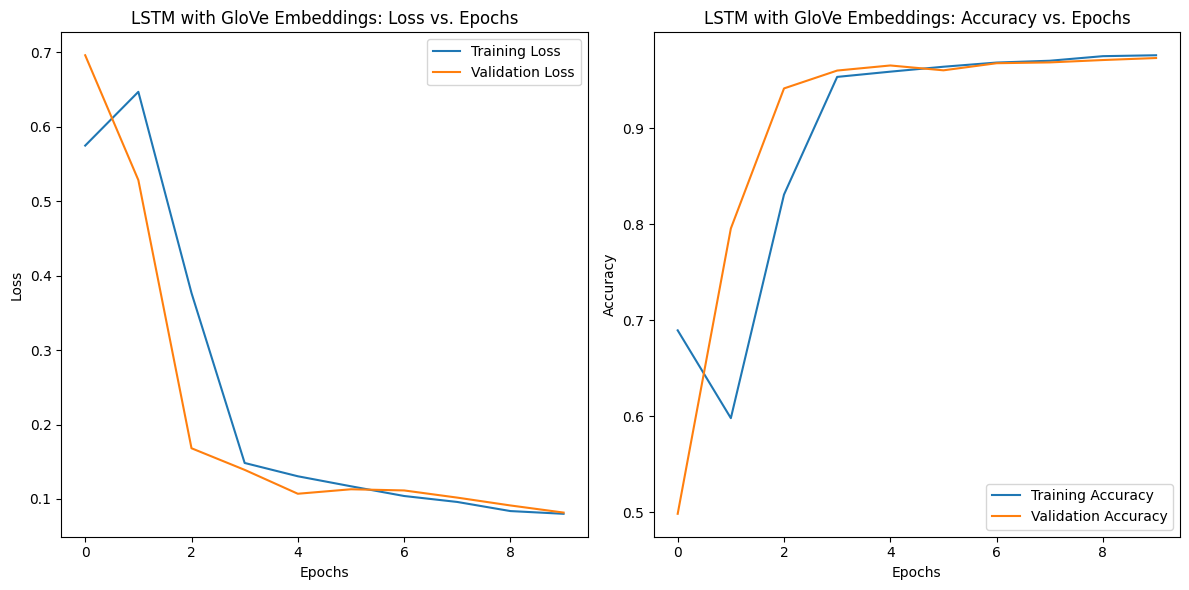

In [319]:
plot_model_performance(lstm_glove_history, "LSTM with GloVe Embeddings")

**Loss vs. Epochs**:
- Trend: Both training and validation loss decrease sharply and converge to very low values, indicating efficient training.
- Convergence: The curves are closely aligned, showing minimal overfitting and excellent generalization.

**Accuracy vs. Epochs**: 
- Trend: Training and validation accuracy improve rapidly, achieving high values (>0.95). The validation accuracy slightly outperforms training accuracy initially, which is common with GloVe embeddings.
- Convergence: Both curves stabilize toward the end, reflecting strong performance and generalization.

**Summary**:  
The model demonstrates smooth and rapid convergence in both loss and accuracy, with minimal overfitting and excellent alignment between training and validation metrics. This suggests outstanding performance.

In [320]:
lstm_glove_plot_rating = 'Very Good'

#### 3.5 Bi-LSTM with TF-IDF

In [321]:
print("Bi-LSTM with TF-IDF...")

bilstm_tfidf, bilstm_tfidf_history = get_or_train_model(
    build_model,
    'bilstm', 'tfidf',
    X_train_tfidf.shape[1],
    X_train_tfidf, y_train,
    X_val_tfidf, y_val,
    model_name="bilstm_tfidf"
)

Bi-LSTM with TF-IDF...
Model loaded from models\bilstm_tfidf.keras
History loaded from models\bilstm_tfidf_history.json
Model and history for 'bilstm_tfidf' loaded successfully.


Model architecture

In [322]:
bilstm_tfidf.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tfidf_layer (InputLayer)        │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_25 (Reshape)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 100, 256)       │       183,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,068,421 (4.08 MB)

 Trainable params: 356,097 (1.36 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 712,196 (2.72 MB)

Evaluate the model on validation set

In [323]:
bilstm_tfidf_metrics = evaluate_model(bilstm_tfidf, X_val_tfidf, y_val)
print("Bi-LSTM with TF-IDF Performance:")
print(bilstm_tfidf_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step
Bi-LSTM with TF-IDF Performance:
{'accuracy': 0.9024270050511273, 'precision': 0.9190861494526416, 'recall': 0.89522484932777, 'f1_score': 0.9069985908877407}


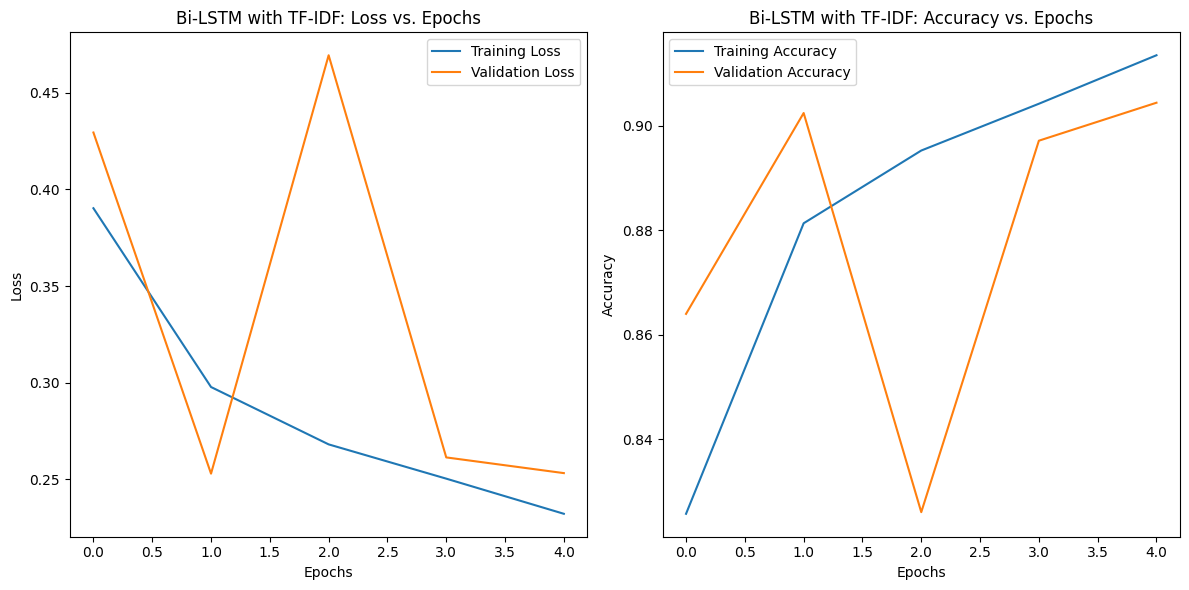

In [324]:
plot_model_performance(bilstm_tfidf_history, "Bi-LSTM with TF-IDF")

**Loss vs. Epochs**:
- Trend: Training loss decreases steadily, but validation loss fluctuates significantly, indicating instability during training.
- Convergence: The sharp spikes in validation loss suggest poor model generalization and inconsistent learning.

**Accuracy vs. Epochs**:
- Trend: While training accuracy improves steadily, validation accuracy exhibits erratic spikes, highlighting overfitting or instability in the training process.
- Convergence: The lack of alignment between training and validation accuracy indicates poor performance and weak generalization.

**Summary**:  
The graphs show significant instability in validation metrics, with erratic trends and large deviations between training and validation performance. This suggests the model struggles to generalize effectively with TF-IDF features.

In [325]:
bilstm_tfidf_plot_rating = 'Bad'

#### 3.6 Bi-LSTM with GloVe Embeddings

In [326]:
print("Bi-LSTM with GloVe Embeddings...")

bilstm_glove, bilstm_glove_history = get_or_train_model(
    build_model,
    'bilstm', 'glove',
    X_train_padded.shape[1],
    X_train_padded, y_train,
    X_val_padded, y_val,
    model_name="bilstm_glove",
    word_index=word_index,
    embedding_matrices=embedding_matrix
)

Bi-LSTM with GloVe Embeddings...
Model loaded from models\bilstm_glove.keras
History loaded from models\bilstm_glove_history.json
Model and history for 'bilstm_glove' loaded successfully.


Model architecture

In [327]:
bilstm_glove.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (InputLayer)    │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_19 (Embedding)        │ (None, 300, 300)       │    48,022,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 300, 256)       │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 300, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,858,921 (190.20 MB)

 Trainable params: 612,097 (2.33 MB)

 Non-trainable params: 48,022,628 (183.19 MB)

 Optimizer params: 1,224,196 (4.67 MB)

Evaluate the model on validation set

In [328]:
bilstm_glove_metrics = evaluate_model(bilstm_glove, X_val_padded, y_val)
print("Bi-LSTM with GloVe Embeddings Performance:")
print(bilstm_glove_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step
Bi-LSTM with GloVe Embeddings Performance:
{'accuracy': 0.9743747690033263, 'precision': 0.9851134215500945, 'recall': 0.9663885025498378, 'f1_score': 0.9756611280131056}


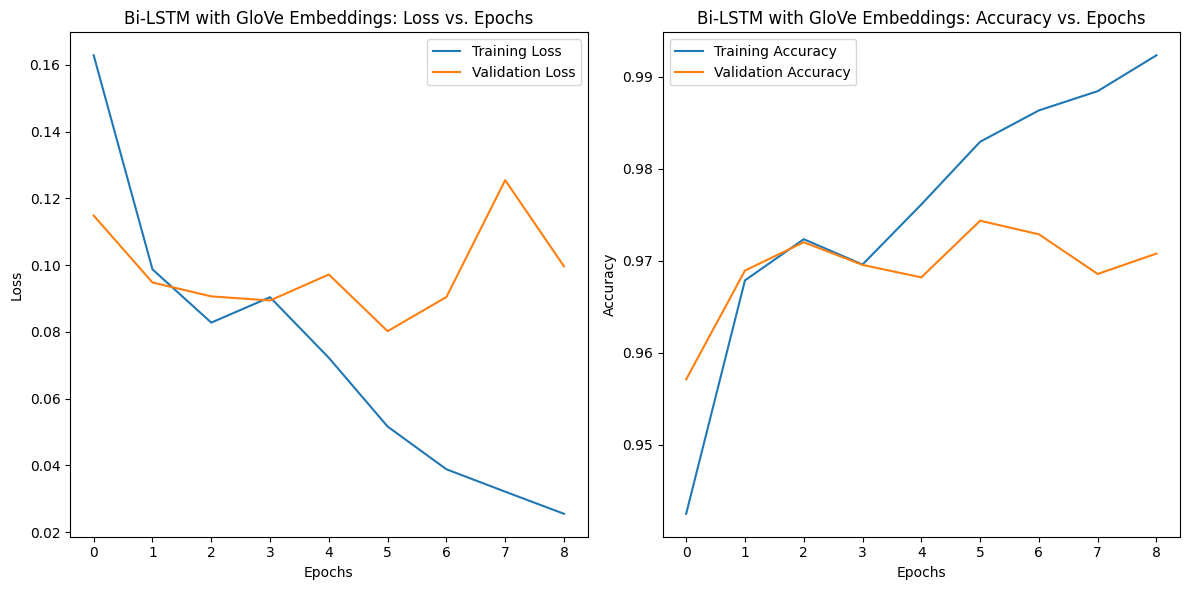

In [329]:
plot_model_performance(bilstm_glove_history, "Bi-LSTM with GloVe Embeddings")

**Loss vs. Epochs**:
- Trend: Training loss decreases steadily, showing effective learning, while validation loss fluctuates after an initial drop.
- Convergence: Although there is some fluctuation in validation loss, it remains relatively low, indicating decent generalization.

**Accuracy vs. Epochs**: 
- Trend: Training and validation accuracy improve rapidly, reaching high levels (>0.97). Validation accuracy is slightly unstable, but it follows the training accuracy closely.
- Convergence: The curves show alignment, with validation accuracy slightly lower but generally consistent.

**Summary**:  
The model achieves high accuracy with aligned trends between training and validation. While minor fluctuations in validation loss and accuracy exist, overall performance is solid with good generalization.

In [330]:
bilstm_glove_plot_rating = 'Good'

#### 3.7 CNN + LSTM Hybrid with TF-IDF

In [331]:
print("CNN + LSTM Hybrid with TF-IDF...")

cnn_lstm_tfidf, cnn_lstm_tfidf_history = get_or_train_model(
    build_model,
    'cnn_lstm', 'tfidf',
    X_train_tfidf.shape[1],
    X_train_tfidf, y_train,
    X_val_tfidf, y_val,
    model_name="cnn_lstm_tfidf"
)

CNN + LSTM Hybrid with TF-IDF...
Model loaded from models\cnn_lstm_tfidf.keras
History loaded from models\cnn_lstm_tfidf_history.json
Model and history for 'cnn_lstm_tfidf' loaded successfully.


In [332]:
cnn_lstm_tfidf.summary()

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tfidf_layer (InputLayer)        │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_28 (Reshape)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 98, 128)        │        19,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 98, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_25         │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_29 (Reshape)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,237 (1.83 MB)

 Trainable params: 159,617 (623.50 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 319,236 (1.22 MB)

Evaluate the model on validation set

In [333]:
cnn_lstm_tfidf_metrics = evaluate_model(cnn_lstm_tfidf, X_val_tfidf, y_val)
print("CNN + LSTM with TF-IDF Performance:")
print(cnn_lstm_tfidf_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
CNN + LSTM with TF-IDF Performance:
{'accuracy': 0.8064555870395467, 'precision': 0.7901417389464777, 'recall': 0.8657858136300417, 'f1_score': 0.8262360358367438}


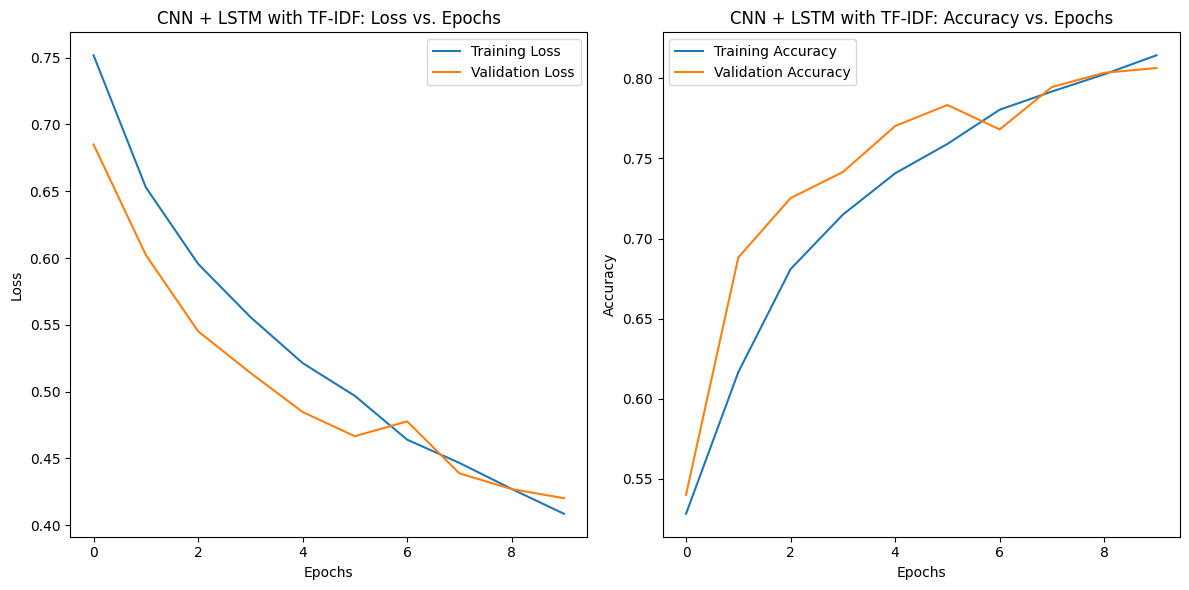

In [334]:
plot_model_performance(cnn_lstm_tfidf_history, "CNN + LSTM with TF-IDF")

**Loss vs. Epochs**:
- Trend: Both training and validation loss decrease steadily, with a slight gap between the curves, indicating effective learning with minimal overfitting.
- Convergence: The trends are consistent, and both losses converge well toward lower values.

**Accuracy vs. Epochs**:
- Trend: Training and validation accuracy improve steadily and converge toward high accuracy values (>0.80). The validation accuracy follows the training accuracy closely.
- Convergence: The curves are well-aligned, with minimal gaps, indicating good generalization.

**Summary**:   
The model demonstrates stable convergence and good alignment between training and validation curves, suggesting effective learning and generalization. While performance is solid, it does not reach "Very Good" due to the slightly lower overall accuracy compared to other models.

In [335]:
cnn_lstm_tfidf_plot_rating = 'Good'

#### 3.8 CNN + LSTM Hybrid with GloVe Embeddings

In [336]:
print("CNN + LSTM with GloVe Embeddings...")

cnn_lstm_glove, cnn_lstm_glove_history = get_or_train_model(
    build_model,
    'cnn_lstm', 'glove',
    X_train_padded.shape[1],
    X_train_padded, y_train,
    X_val_padded, y_val,
    model_name="cnn_lstm_glove",
    word_index=word_index,
    embedding_matrices=embedding_matrix
)

CNN + LSTM with GloVe Embeddings...
Model loaded from models\cnn_lstm_glove.keras
History loaded from models\cnn_lstm_glove_history.json
Model and history for 'cnn_lstm_glove' loaded successfully.


In [337]:
cnn_lstm_glove.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (InputLayer)    │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_20 (Embedding)        │ (None, 300, 300)       │    48,022,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 298, 128)       │       115,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 298, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_26         │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_30 (Reshape)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,789,737 (186.12 MB)

 Trainable params: 255,617 (998.50 KB)

 Non-trainable params: 48,022,884 (183.19 MB)

 Optimizer params: 511,236 (1.95 MB)

Evaluate the model on validation set

In [338]:
cnn_lstm_glove_metrics = evaluate_model(cnn_lstm_glove, X_val_padded, y_val)
print("CNN + LSTM with TF-IDF Performance:")
print(cnn_lstm_glove_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
CNN + LSTM with TF-IDF Performance:
{'accuracy': 0.96957003819145, 'precision': 0.9767878077373974, 'recall': 0.9656930922577655, 'f1_score': 0.9712087655903952}


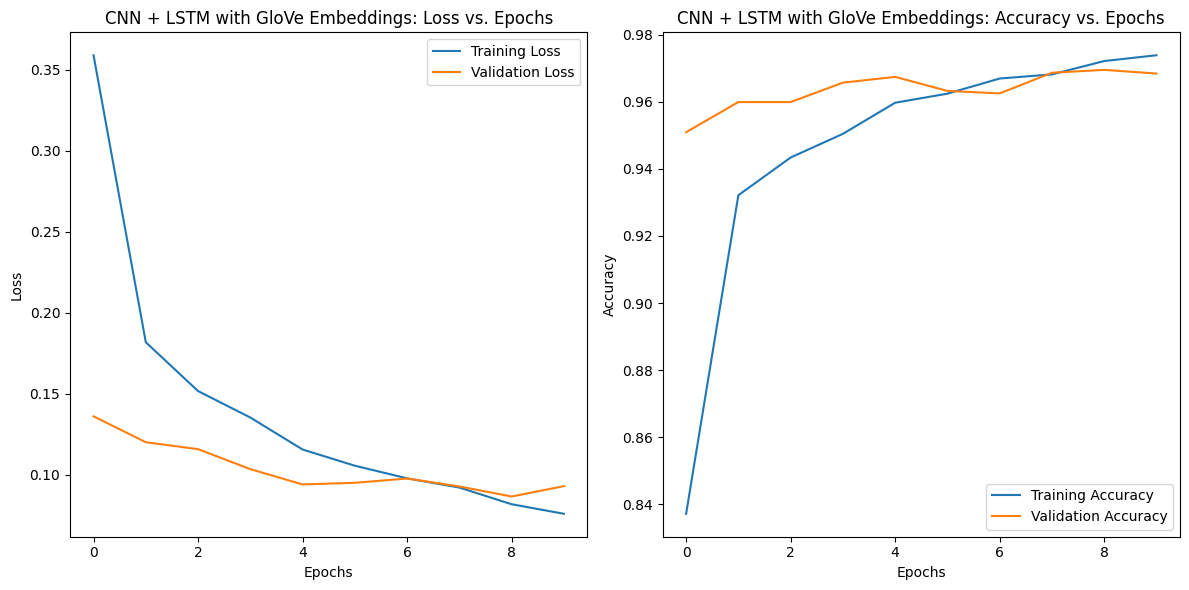

In [339]:
plot_model_performance(cnn_lstm_glove_history, "CNN + LSTM with GloVe Embeddings")

**Loss vs. Epochs**:
- Trend: Training and validation loss decrease steadily and converge to very low values, indicating efficient training and good generalization.
- Convergence: The curves are closely aligned, with no significant gap, suggesting minimal overfitting.

**Accuracy vs. Epochs**:
- Trend: Training and validation accuracy improve rapidly, reaching high levels (>0.96). The validation accuracy is slightly lower but closely follows the training accuracy.
- Convergence: The curves stabilize toward the end, demonstrating strong performance and alignment.

**Summary**:  
The model shows excellent convergence in both loss and accuracy, with aligned training and validation metrics, minimal overfitting, and strong generalization. This is among the best-performing configurations.

In [340]:
cnn_lstm_glove_plot_rating = 'Very Good'

#### 3.9 Bi-LSTM with TF-IDF (Attention Mechanisms)

In [341]:
print("Bi-LSTM with TF-IDF (Attention Mechanisms)...")

bilstm_attention_tfidf, bilstm_attention_tfidf_history = get_or_train_model(
    build_model,
    'bilstm_attention', 'tfidf',
    X_train_tfidf.shape[1],
    X_train_tfidf, y_train,
    X_val_tfidf, y_val,
    model_name="bilstm_attention_tfidf"
)

Bi-LSTM with TF-IDF (Attention Mechanisms)...
Model loaded from models\bilstm_attention_tfidf.keras
History loaded from models\bilstm_attention_tfidf_history.json
Model and history for 'bilstm_attention_tfidf' loaded successfully.


In [342]:
bilstm_attention_tfidf.summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tfidf_layer         │ (None, 5000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_36          │ (None, 100, 50)   │          0 │ tfidf_layer[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_25    │ (None, 100, 256)  │    183,296 │ reshape_36[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_125         │ (None, 100, 256)  │          0 │ bidirectional_25… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_100 (Dense)   │ (None, 100, 256)  │     65,792 │ dropout_125[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_5         │ (None, 100, 256)  │          0 │ dense_100[0][0],  │
│ (Attention)         │                   │            │ dropout_125[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ attention_5[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_101 (Dense)   │ (None, 64)        │     16,448 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_101[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_126         │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_102 (Dense)   │ (None, 1)         │         65 │ dropout_126[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 797,317 (3.04 MB)

 Trainable params: 265,729 (1.01 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 531,460 (2.03 MB)

Evaluate the model on validation set

In [343]:
bilstm_attention_tfidf_metrics = evaluate_model(bilstm_attention_tfidf, X_val_tfidf, y_val)
print("Bi-LSTM with TF-IDF (Attention Mechanisms) Performance:")
print(bilstm_attention_tfidf_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step
Bi-LSTM with TF-IDF (Attention Mechanisms) Performance:
{'accuracy': 0.9273130466921277, 'precision': 0.9212669683257918, 'recall': 0.9439035697728326, 'f1_score': 0.9324479047400962}


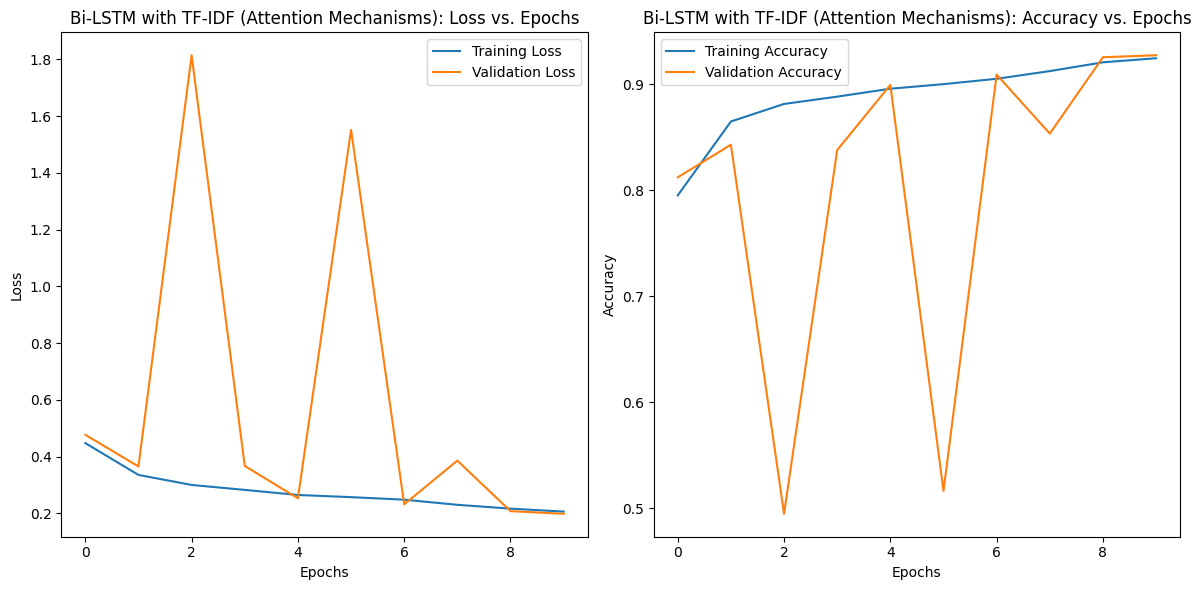

In [344]:
plot_model_performance(bilstm_attention_tfidf_history, "Bi-LSTM with TF-IDF (Attention Mechanisms)")

**Loss vs. Epochs**:
- Trend: Training loss decreases steadily, indicating effective learning. However, validation loss fluctuates dramatically with large spikes, showing instability.
- Convergence: The lack of consistency in validation loss suggests poor generalization and potential issues with overfitting or data incompatibility with the model.

**Accuracy vs. Epochs**:
- Trend: Training accuracy improves steadily, while validation accuracy fluctuates sharply, mirroring the instability seen in validation loss.
- Convergence: The erratic behavior of validation accuracy indicates significant instability, with poor alignment between training and validation curves.

**Summary**:  
The extreme fluctuations in validation loss and accuracy highlight severe instability and poor generalization. This suggests the model struggles to handle TF-IDF features effectively, even with attention mechanisms.

In [345]:
bilstm_attention_tfidf_plot_rating = 'Very Bad'

#### 3.10 Bi-LSTM with GloVe Embeddings (Attention Mechanisms)

In [346]:
print("Bi-LSTM with GloVe Embeddings (Attention Mechanisms)...")

bilstm_attention_glove, bilstm_attention_glove_history = get_or_train_model(
    build_model,
    'bilstm_attention', 'glove',
    X_train_padded.shape[1],
    X_train_padded, y_train,
    X_val_padded, y_val,
    model_name="bilstm_attention_glove",
    word_index=word_index,
    embedding_matrices=embedding_matrix
)

Bi-LSTM with GloVe Embeddings (Attention Mechanisms)...
Model loaded from models\bilstm_attention_glove.keras
History loaded from models\bilstm_attention_glove_history.json
Model and history for 'bilstm_attention_glove' loaded successfully.


In [347]:
bilstm_attention_glove.summary()

Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embedding_layer     │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_21        │ (None, 300, 300)  │ 48,022,500 │ embedding_layer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_26    │ (None, 300, 256)  │    439,296 │ embedding_21[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_127         │ (None, 300, 256)  │          0 │ bidirectional_26… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_103 (Dense)   │ (None, 300, 256)  │     65,792 │ dropout_127[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_6         │ (None, 300, 256)  │          0 │ dense_103[0][0],  │
│ (Attention)         │                   │            │ dropout_127[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ attention_6[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_104 (Dense)   │ (None, 64)        │     16,448 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_104[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_128         │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_105 (Dense)   │ (None, 1)         │         65 │ dropout_128[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,587,817 (189.16 MB)

 Trainable params: 521,729 (1.99 MB)

 Non-trainable params: 48,022,628 (183.19 MB)

 Optimizer params: 1,043,460 (3.98 MB)

Evaluate the model on validation set

In [348]:
bilstm_attention_glove_metrics = evaluate_model(bilstm_attention_glove, X_val_padded, y_val)
print("Bi-LSTM with GloVe Embeddings (Attention Mechanisms) Performance:")
print(bilstm_attention_glove_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step
Bi-LSTM with GloVe Embeddings (Attention Mechanisms) Performance:
{'accuracy': 0.9775779228779106, 'precision': 0.9822595704948646, 'recall': 0.9754288363467779, 'f1_score': 0.978832286578274}


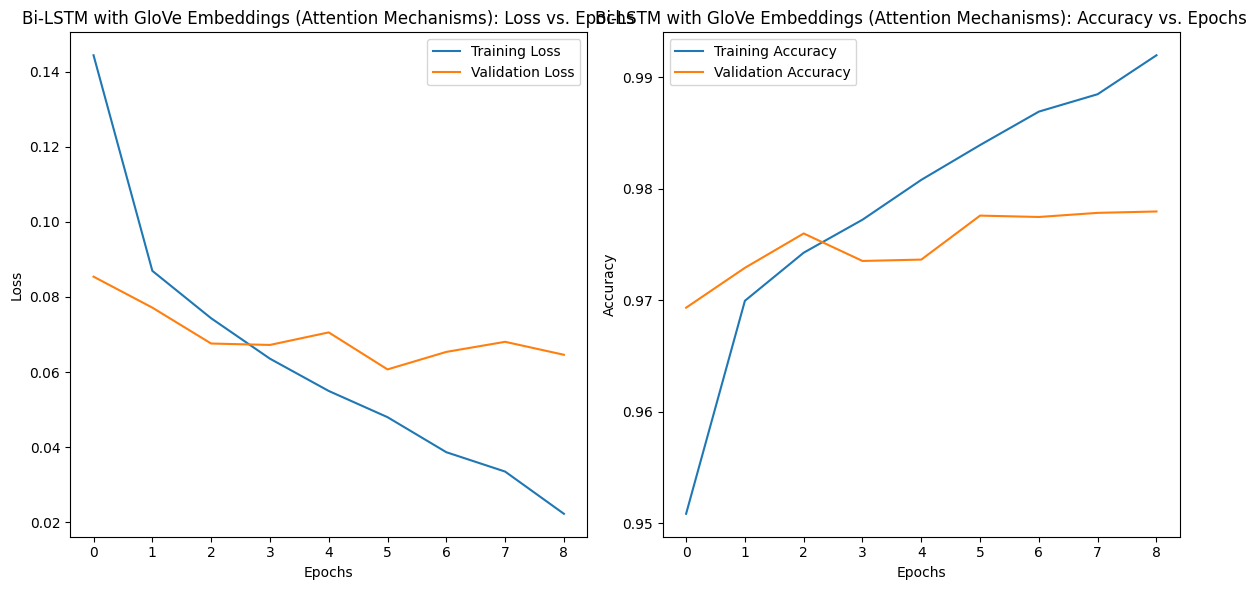

In [349]:
plot_model_performance(bilstm_attention_glove_history, "Bi-LSTM with GloVe Embeddings (Attention Mechanisms)")

**Loss vs. Epochs**:
- Trend: Training loss decreases steadily, indicating effective learning, while validation loss stabilizes at a low value with minor fluctuations.
- Convergence: The close alignment of training and validation loss demonstrates minimal overfitting and good generalization.

**Accuracy vs. Epochs**:
- Trend: Training and validation accuracy improve rapidly, reaching high values (>0.97). Validation accuracy stabilizes well toward the later epochs, closely following the training accuracy.
- Convergence: The curves are closely aligned, with the validation accuracy maintaining stability and demonstrating excellent generalization.

**Summary**:  
The graphs indicate smooth and stable convergence in both loss and accuracy, with high performance and minimal overfitting. The addition of attention mechanisms enhances the interpretability without compromising performance, making this one of the best configurations.

In [350]:
bilstm_attention_glove_plot_rating = 'Very Good'

#### 3.11 Top-Performing Models Selection

The selection of top-performing models is based on their evaluation metrics, including accuracy, precision, recall, and F1-score, alongside the assigned plot ratings for training and validation trends. These criteria ensure that the selected models not only perform well but also demonstrate stable and reliable learning behavior.

In [351]:
# Function to compile models metrics into one DataFrame
def compile_metrics(models_metrics, plot_ratings):

    metrics_df = pd.DataFrame(models_metrics)
    metrics_df['Plots Rating'] = plot_ratings
    metrics_df.sort_values('accuracy', ascending=False, inplace=True)

    display(metrics_df)

In [352]:
compile_metrics([
    {**cnn_tfidf_metrics, 'Model': 'CNN with TF-IDF'},
    {**cnn_glove_metrics, 'Model': 'CNN with GloVe'},
    {**lstm_tfidf_metrics, 'Model': 'LSTM with TF-IDF'},
    {**lstm_glove_metrics, 'Model': 'LSTM with GloVe'},
    {**bilstm_tfidf_metrics, 'Model': 'Bi-LSTM with TF-IDF'},
    {**bilstm_glove_metrics, 'Model': 'Bi-LSTM with GloVe'},
    {**cnn_lstm_tfidf_metrics, 'Model': 'CNN + LSTM with TF-IDF'},
    {**cnn_lstm_glove_metrics, 'Model': 'CNN + LSTM with GloVe'},
    {**bilstm_attention_tfidf_metrics, 'Model': 'Bi-LSTM with TF-IDF (Attention)'},
    {**bilstm_attention_glove_metrics, 'Model': 'Bi-LSTM with GloVe (Attention)'}],
    [ccn_tfidf_plot_rating, cnn_glove_plot_rating, 
     lstm_tfidf_plot_rating, lstm_glove_plot_rating, 
     bilstm_tfidf_plot_rating, bilstm_glove_plot_rating,
     cnn_lstm_tfidf_plot_rating, cnn_lstm_glove_plot_rating,
     bilstm_attention_tfidf_plot_rating, bilstm_attention_glove_plot_rating]
)

,accuracy,precision,recall,f1_score,Model,Plots Rating
9,0.977578,0.982260,0.975429,0.978832,Bi-LSTM with GloVe (Attention),Very Good
5,0.974375,0.985113,0.966389,0.975661,Bi-LSTM with GloVe,Good
3,0.973020,0.983015,0.965925,0.974395,LSTM with GloVe,Very Good
1,0.970679,0.982253,0.962216,0.972131,CNN with GloVe,Very Good
7,0.969570,0.976788,0.965693,0.971209,CNN + LSTM with GloVe,Very Good
2,0.931748,0.956311,0.913306,0.934313,LSTM with TF-IDF,Good
8,0.927313,0.921267,0.943904,0.932448,Bi-LSTM with TF-IDF (Attention),Very Bad
4,0.902427,0.919086,0.895225,0.906999,Bi-LSTM with TF-IDF,Bad
6,0.806456,0.790142,0.865786,0.826236,CNN + LSTM with TF-IDF,Good
0,0.801774,0.834529,0.782105,0.807467,CNN with TF-IDF,Good


**Top Models**

1. **Bi-LSTM with GloVe (Attention)**:
   - Achieved the highest accuracy (0.977578) and F1-score (0.978832), demonstrating superior performance.
   - The "Very Good" plot rating confirms stable and consistent learning behavior.
   - Selected as the best overall model for its excellent balance of performance and stability.

2. **Bi-LSTM with GloVe**:
   - Ranked second with an accuracy of 0.974375 and F1-score of 0.975661.
   - Good generalization with a "Good" plot rating, making it a reliable option.

3. **LSTM with GloVe**:
   - Achieved an accuracy of 0.973020 and a "Very Good" plot rating, highlighting its strong performance and stability.
   - Chosen for its competitive metrics and robust training behavior.

4. **CNN with GloVe**:
   - Demonstrated consistent performance with an accuracy of 0.970679 and F1-score of 0.972131.
   - "Very Good" plot rating reinforces its generalization and training consistency.

5. **CNN + LSTM with GloVe**:
   - Slightly lower accuracy (0.969570) but maintained a strong F1-score of 0.971209.
   - Its "Very Good" plot rating reflects strong convergence and stability.

**Conclusion**  
The Bi-LSTM with GloVe (Attention) model is selected as the top-performing model due to its outstanding performance across all evaluation metrics and stability during training. Other models such as LSTM with GloVe, CNN with GloVe, and CNN + LSTM with GloVe are recommended as strong alternatives, showcasing high accuracy and reliable generalization.

## Section 4: Hyperparameter Tuning

Hyperparameter tuning plays a vital role in optimizing deep learning models. For this project, KerasTuner's Hyperband strategy was employed to identify the optimal set of hyperparameters for various model architectures, including CNN, LSTM, Bi-LSTM, Bi-LSTM with Attention Mechanisms, and CNN + LSTM, all using GloVe embeddings. The tuning process aimed to maximize metrics such as accuracy, precision, recall, and F1-score.

The following hyperparameters were tuned during the process:
- **Kernal Regularization**: Options include `none`, `l1`, `l2`, `l1_l2`, with dynamically tuned regularization values.
- **Dropout Rates**: Explored values ranges from 0.2 to 0.5 to prevent overfitting.
- **Layer Configuration**:
    - Kernel Size: 3, 5, 7
    - CNN Units: 64 to 256
    - LSTM Units: 64 to 256
    - Dense Units: 64 to 256
- **Learning Rate**: Tuned values ranged 10<sup>-4</sup> to 10<sup>-2</sup>, sampled on a logarithmic scale.
- **Optimizer**: Options included `adam`, `rmsprop`, and `sgd`.

The Hyperband tuning strategy was chosen for its efficiency in balancing resource allocation and performance. Early stopping was employed to monitor validation loss and prevent overfitting, with training halting after 3 epochs of no improvement. The best model and hyperparameters were saved for each architecture, enabling easy retrieval and avoiding redundant tuning.

After identifying the optimal hyperparameters, the best models were retrained using the tuned configurations to refine their performance further. 

In [353]:
# Model builder for KerasTuner
def model_builder(hp, model_type):

    # Define input layer
    input_layer = Input(shape=(X_train_padded.shape[1],), name='embedding_input')

    # Embedding layer with pre-trained GloVe weights
    embedding_layer = Embedding(
        input_dim=len(word_index) + 1,
        output_dim=embedding_matrix.shape[1],
        input_length=X_train_padded.shape[1],
        weights=[embedding_matrix],
        trainable=False
    )(input_layer)
    
    # Define kernel_regularizer outside of the layer definitions
    regularizer_choice = hp.Choice('kernel_regularizer', ['none', 'l1', 'l2', 'l1_l2'])
    if regularizer_choice == 'none':
        kernel_regularizer = None
    elif regularizer_choice == 'l1':
        kernel_regularizer = l1(hp.Float('l1_value', min_value=1e-5, max_value=1e-2, sampling='log'))
    elif regularizer_choice == 'l2':
        kernel_regularizer = l2(hp.Float('l2_value', min_value=1e-5, max_value=1e-2, sampling='log'))
    elif regularizer_choice == 'l1_l2':
        kernel_regularizer = l1_l2(
            l1=hp.Float('l1_value', min_value=1e-5, max_value=1e-2, sampling='log'),
            l2=hp.Float('l2_value', min_value=1e-5, max_value=1e-2, sampling='log'))

    if model_type == 'cnn':
        
        # CNN Layers
        layer = Conv1D(
            filters=hp.Int('filters', min_value=64, max_value=256, step=32),
            kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
            activation='relu',
            kernel_regularizer= kernel_regularizer
        )(embedding_layer)
        layer = BatchNormalization()(layer)
        layer = GlobalMaxPooling1D()(layer)
        layer = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(layer)

    elif model_type == 'lstm':

        # First LSTM Layer
        layer = LSTM(
            units=hp.Int("lstm_units", min_value=64, max_value=256, step=32),
            return_sequences=True,
            kernel_regularizer= kernel_regularizer
        )(embedding_layer)
        layer = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(layer)
        
        # Second LSTM Layer
        layer = LSTM(
            64, 
            return_sequences=False,
            kernel_regularizer= kernel_regularizer
        )(layer)
        layer = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(layer)

    elif model_type == 'bilstm':

        # Dynamic bilstm_units
        bilstm_units = hp.Int("lstm_units", min_value=64, max_value=256, step=32)

        # First Bi-LSTM Layer
        layer = Bidirectional(LSTM(
            units=bilstm_units,
            return_sequences=True,
            kernel_regularizer= kernel_regularizer)
        )(embedding_layer)
        layer = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(layer)

        # Second Bi-LSTM Layer
        layer = Bidirectional(LSTM(
            64, 
            return_sequences=False,
            kernel_regularizer= kernel_regularizer)
        )(layer)
        layer = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(layer)

    elif model_type == 'cnn_lstm':

        # CNN Layers
        cnn_layer = Conv1D(
            filters=hp.Int('filters', min_value=64, max_value=256, step=32),
            kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
            activation='relu',
            kernel_regularizer= kernel_regularizer
        )(embedding_layer)
        cnn_layer = BatchNormalization()(cnn_layer)
        cnn_layer = GlobalMaxPooling1D()(cnn_layer)
        cnn_layer = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(cnn_layer)

        # Expand dimensions to match LSTM input
        lstm_input = Reshape((1, -1))(cnn_layer)

        # LSTM Layer
        layer = LSTM(
            128, 
            return_sequences=False,
            kernel_regularizer= kernel_regularizer
        )(lstm_input)
        layer = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(layer)

    elif model_type == 'bilstm_attention':
        
        # Dynamic bilstm_units
        bilstm_units = hp.Int("lstm_units", min_value=64, max_value=256, step=32)

        # Bi-LSTM Layer
        bilstm_layer = Bidirectional(LSTM(
            units=bilstm_units,
            return_sequences=True,
            kernel_regularizer= kernel_regularizer)
        )(embedding_layer)
        bilstm_layer = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(bilstm_layer)

        # Attention Layer
        query = Dense(2 * bilstm_units)(bilstm_layer)
        attention_output = Attention()([query, bilstm_layer])

        # Pooling layer to reduce sequence dimension
        layer = GlobalMaxPooling1D()(attention_output)

    else:
        raise ValueError("Invalid model_type specified!")

    # Fully connected layer
    final_layer = Dense(
        hp.Int("dense_units", min_value=64, max_value=256, step=32),
        activation='relu',
        kernel_regularizer= kernel_regularizer
    )(layer)
    final_layer = BatchNormalization()(final_layer)
    final_layer = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(final_layer)

    output = Dense(1, activation='sigmoid')(final_layer)

    model = Model(inputs=input_layer, outputs=output)

    # Compile the model
    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    if optimizer_choice == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model


In [354]:
# Initialize the tuner
def tune_model(model_type):
    
    tuner = kt.Hyperband(
        lambda hp: model_builder(hp, model_type),
        objective='val_accuracy',
        max_epochs=20,
        factor=3,
        directory='tuner_dir',
        project_name=f"{model_type}_tuning"
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Perform hyperparameter tuning
    tuner.search(X_train_padded, y_train, validation_data=(X_val_padded, y_val), epochs=20, callbacks=[early_stopping], batch_size=128)

    # Get the best hyperparameters and model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]

    print(f"Best Hyperparameters for {model_type}:")
    for key, value in best_hps.values.items():
        print(f"{key}: {value}")

    return best_hps, best_model

In [355]:
# Save the best hyperparameters and model after hyperparameter tuning.
def save_best_model_and_hps(best_hps, best_model, model_name, save_dir="tuned_models"):
    
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the model
    model_path = os.path.join(save_dir, f"{model_name}_best_model.keras")
    best_model.save(model_path)
    
    print(f"Best model saved to {model_path}")

    # Save the hyperparameters
    hps_path = os.path.join(save_dir, f"{model_name}_best_hps.json")
    best_hps_dict = best_hps.values

    with open(hps_path, "w") as hps_file:
        json.dump(best_hps_dict, hps_file)

    print(f"Best hyperparameters saved to {hps_path}")

In [356]:
# Load the best hyperparameters and model if they exist.
def load_best_model_and_hps(model_name, save_dir="tuned_models"):
    
    model_path = os.path.join(save_dir, f"{model_name}_best_model.keras")
    hps_path = os.path.join(save_dir, f"{model_name}_best_hps.json")

    if os.path.exists(model_path) and os.path.exists(hps_path):
        # Load the model
        best_model = load_model(model_path)

        print(f"Best model loaded from {model_path}")

        # Load the hyperparameters
        with open(hps_path, "r") as hps_file:
            best_hps = json.load(hps_file)
            
        print(f"Best hyperparameters loaded from {hps_path}")
        
        return best_model, best_hps

    return None, None

In [357]:
# Tune a model or load it if already saved.
def tune_or_load_model(model_name, save_dir="tuned_models"):
    
    # Check if tuned model exists
    best_model, best_hps = load_best_model_and_hps(model_name, save_dir)

    if best_model is not None and best_hps is not None:

        return best_model, best_hps
    
    # If not, tune the model
    best_hps, best_model = tune_model(model_name)
    
    print(f"Best hyperparameters for {model_name}: {best_hps.values}")
    
    save_best_model_and_hps(best_hps, best_model, model_name, save_dir)
    
    return best_model, best_hps

In [358]:
# Re-train the best model and capture the history
def retrain_best_model_and_save_history(best_model, best_hps, model_name, X_train, y_train, X_val, y_val, epochs=20, batch_size=128):
    
    # History path
    history_path = os.path.join("tuned_models", f"{model_name}_history.json")

    # Check if history file exists
    if os.path.exists(history_path):
        print(f"History file '{history_path}' found. Loading existing training history...")

        with open(history_path, "r") as json_file:
            loaded_history = json.load(json_file)

        print(f"Loaded history: {list(loaded_history.keys())}")

        return loaded_history
    
    # If no history file, retrain the model
    print("Retraining the best model with the following hyperparameters:")


    if isinstance(best_hps, dict):  # Handle dictionary objects
        for key, value in best_hps.items():
            print(f"{key}: {value}")
    elif isinstance(best_hps, kt.HyperParameters):  # Handle KerasTuner HyperParameters objects
        for key, value in best_hps.values.items():
            print(f"{key}: {value}")
    else:
        raise ValueError("Unsupported type for best_hps. Must be a dictionary or keras_tuner.HyperParameters object.")

    # Retrain the best model
    history = best_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Save the history as a JSON file
    history_data = history.history

    with open(history_path, "w") as json_file:
        json.dump(history_data, json_file)

    print(f"Training history saved to {history_path}")

    return history_data


### 4.1 Bi-LSTM with GloVe Embeddings (Attention Mechanism)

In [359]:
print("Tuning Bi-LSTM with GloVe Embeddings (Attention Mechanisms)...")
bilstm_attention_best_model, bilstm_attention_best_hps = tune_or_load_model('bilstm_attention')

Tuning Bi-LSTM with GloVe Embeddings (Attention Mechanisms)...
Best model loaded from tuned_models\bilstm_attention_best_model.keras
Best hyperparameters loaded from tuned_models\bilstm_attention_best_hps.json


C:\Users\WeiZhenLim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [360]:
print(bilstm_attention_best_hps)

{'kernel_regularizer': 'none', 'lstm_units': 160, 'dropout': 0.2, 'dense_units': 256, 'optimizer': 'adam', 'learning_rate': 0.00526060993003738, 'l2_value': 3.357172354831777e-05, 'l1_value': 4.709822358082974e-05, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


In [361]:
bilstm_attention_best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ embedding_input     │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 300, 300)  │ 48,022,500 │ embedding_input[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 300, 320)  │    590,080 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 300, 320)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 300, 320)  │    102,720 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 300, 320)  │          0 │ dense[0][0],      │
│ (Attention)         │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 320)       │          0 │ attention[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     82,176 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,350,249 (192.07 MB)

 Trainable params: 775,745 (2.96 MB)

 Non-trainable params: 48,023,012 (183.19 MB)

 Optimizer params: 1,551,492 (5.92 MB)

In [362]:
bilstm_attention_best_model_metrics = evaluate_model(bilstm_attention_best_model, X_val_padded, y_val)
print("Bi-LSTM with GloVe Embeddings (Attention Mechanisms) Performance:")
print(bilstm_attention_best_model_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step
Bi-LSTM with GloVe Embeddings (Attention Mechanisms) Performance:
{'accuracy': 0.9802882838487126, 'precision': 0.9832480223359702, 'recall': 0.9796012980992118, 'f1_score': 0.981421272642824}


In [363]:
bilstm_attention_best_model_history = retrain_best_model_and_save_history(
    bilstm_attention_best_model, bilstm_attention_best_hps, 'tuned_bilstm_attention', 
    X_train_padded, y_train, X_val_padded, y_val)

History file 'tuned_models\tuned_bilstm_attention_history.json' found. Loading existing training history...
Loaded history: ['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall']


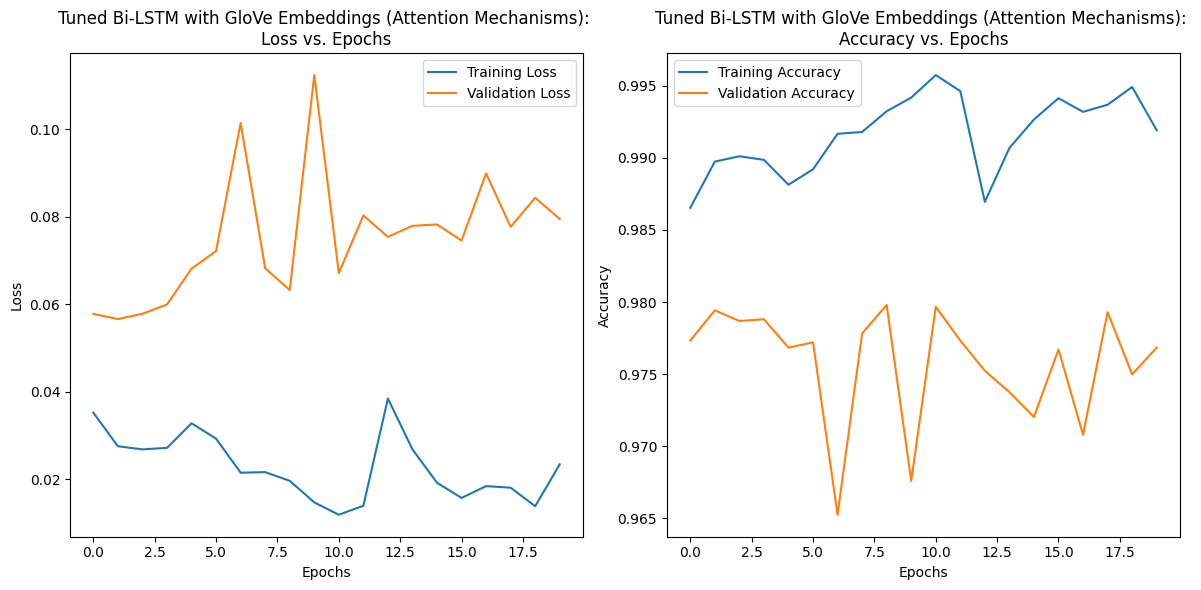

In [364]:
plot_model_performance(bilstm_attention_best_model_history, "Tuned Bi-LSTM with GloVe Embeddings (Attention Mechanisms)", True)

**Loss vs. Epochs**:
- Training Loss: Demonstrates a consistent downward trend, indicating that the model learns effectively throughout the epochs.
- Validation Loss: Fluctuates significantly with peaks and troughs, reflecting instability during validation. This suggests potential overfitting or sensitivity to the validation data.

**Accuracy vs. Epochs**:
- Training Accuracy: Maintains high and stable accuracy across epochs, indicating the model effectively captures patterns in the training data.
- Validation Accuracy: Shows significant fluctuations, with frequent drops despite achieving high accuracy at certain points. This inconsistency highlights potential overfitting or challenges in generalizing to unseen data.

**Summary**:  
While the training performance is robust, the unstable validation performance, reflected in both loss and accuracy, diminishes the overall reliability of the model. Therefore, the plots rating is <span style='color:green'> **"Good"** </span> due to its solid training metrics but inconsistent validation trends.

### 4.2 Bi-LSTM with GloVe Embeddings

In [365]:
print("Tuning Bi-LSTM with GloVe Embeddings...")
bilstm_best_model, bilstm_best_hps = tune_or_load_model('bilstm')

Tuning Bi-LSTM with GloVe Embeddings...
Best model loaded from tuned_models\bilstm_best_model.keras
Best hyperparameters loaded from tuned_models\bilstm_best_hps.json


C:\Users\WeiZhenLim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [366]:
print(bilstm_best_hps)

{'kernel_regularizer': 'none', 'lstm_units': 128, 'dropout': 0.4, 'dense_units': 64, 'optimizer': 'adam', 'learning_rate': 0.0022559447282506848, 'l1_value': 0.00021777965369913825, 'l2_value': 4.077009551121298e-05, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


In [367]:
bilstm_best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_input (InputLayer)    │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 300)       │    48,022,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 300, 256)       │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 300, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,858,921 (190.20 MB)

 Trainable params: 612,097 (2.33 MB)

 Non-trainable params: 48,022,628 (183.19 MB)

 Optimizer params: 1,224,196 (4.67 MB)

In [368]:
bilstm_best_model_metrics = evaluate_model(bilstm_best_model, X_val_padded, y_val)
print("Bi-LSTM with GloVe Embeddings Performance:")
print(bilstm_best_model_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step
Bi-LSTM with GloVe Embeddings Performance:
{'accuracy': 0.9795490944930393, 'precision': 0.987312030075188, 'recall': 0.9740380157626333, 'f1_score': 0.9806301050175029}


In [369]:
bilstm_best_model_history = retrain_best_model_and_save_history(
    bilstm_best_model, bilstm_best_hps, 'tuned_bilstm', 
    X_train_padded, y_train, X_val_padded, y_val)

History file 'tuned_models\tuned_bilstm_history.json' found. Loading existing training history...
Loaded history: ['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall']


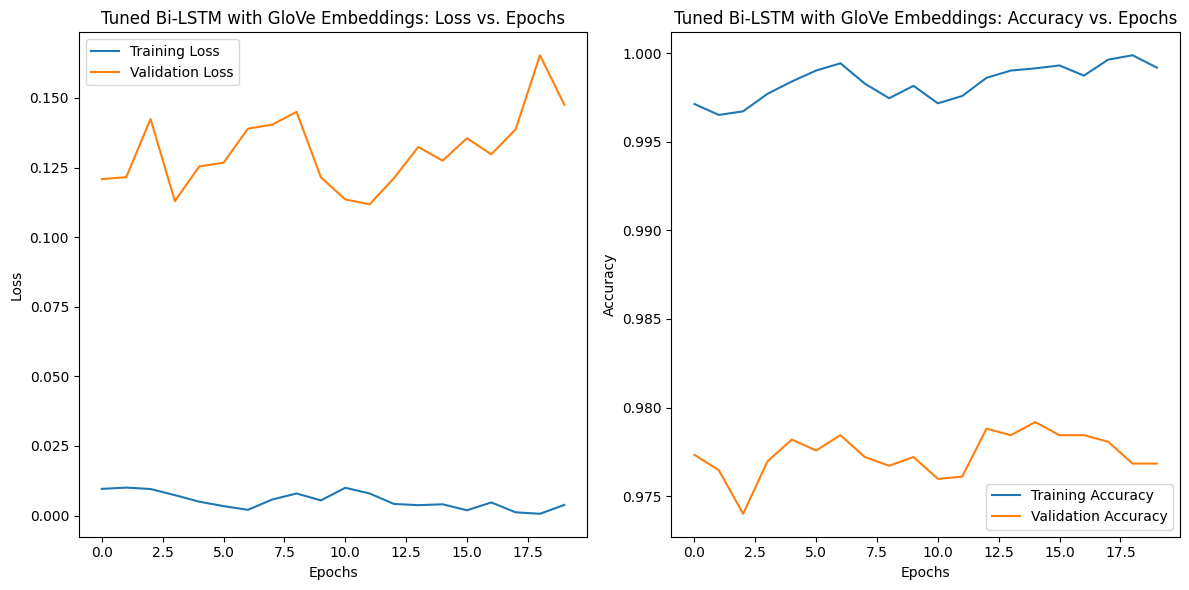

In [370]:
plot_model_performance(bilstm_best_model_history, "Tuned Bi-LSTM with GloVe Embeddings")

**Loss vs. Epochs**:
- Training Loss: Remains consistently low, indicating excellent learning on the training data throughout the epochs.
- Validation Loss: Displays a gradual upward trend with notable fluctuations. This behavior suggests overfitting as the model performs better on the training data than on the validation data.

**Accuracy vs. Epochs**:
- Training Accuracy: Maintains an exceptionally high and consistent level, reaching nearly perfect accuracy.
- Validation Accuracy: Experiences fluctuations and a slight downward trend, indicating challenges in generalizing to unseen data.

**Summary**:  
The model demonstrates strong training performance, but the increasing validation loss and fluctuating validation accuracy indicate potential overfitting. The plots rating is <span style='color:green'> **"Good"** </span> due to the reliable training metrics but less stable validation performance.

### 4.3 LSTM with GloVe Embeddings

In [371]:
print("Tuning LSTM with GloVe Embeddings...")
lstm_best_model, lstm_best_hps = tune_or_load_model('lstm')

Tuning LSTM with GloVe Embeddings...
Best model loaded from tuned_models\lstm_best_model.keras
Best hyperparameters loaded from tuned_models\lstm_best_hps.json


C:\Users\WeiZhenLim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [372]:
print(lstm_best_hps)

{'kernel_regularizer': 'none', 'lstm_units': 256, 'dropout': 0.30000000000000004, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.001945510412913914, 'l2_value': 0.0059804502808629935, 'l1_value': 0.0007343120079351318, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0019'}


In [373]:
lstm_best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_input (InputLayer)    │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 300)       │    48,022,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 300, 256)       │       570,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 300, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,336,424 (188.20 MB)

 Trainable params: 656,897 (2.51 MB)

 Non-trainable params: 48,022,628 (183.19 MB)

 Optimizer params: 656,899 (2.51 MB)

In [374]:
lstm_best_model_metrics = evaluate_model(lstm_best_model, X_val_padded, y_val)
print("LSTM with GloVe Embeddings Performance:")
print(lstm_best_model_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 53s 208ms/step
LSTM with GloVe Embeddings Performance:
{'accuracy': 0.9789331033633115, 'precision': 0.9902958579881657, 'recall': 0.9698655540101994, 'f1_score': 0.9799742358589999}


In [375]:
lstm_best_model_history = retrain_best_model_and_save_history(
    lstm_best_model, lstm_best_hps, 'tuned_lstm', 
    X_train_padded, y_train, X_val_padded, y_val)

History file 'tuned_models\tuned_lstm_history.json' found. Loading existing training history...
Loaded history: ['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall']


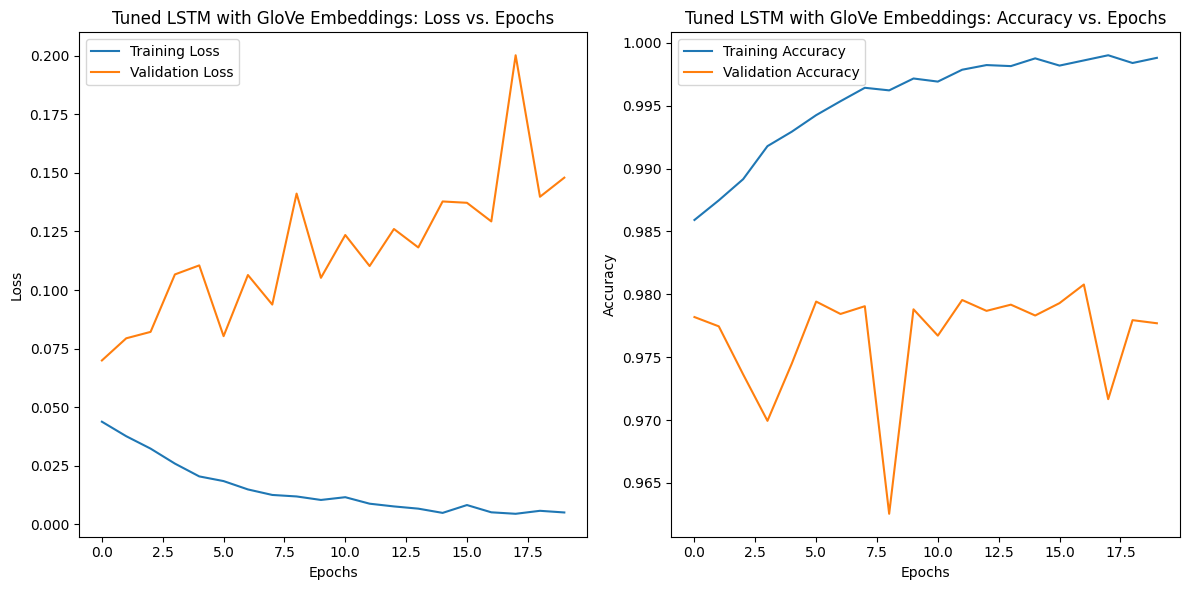

In [376]:
plot_model_performance(lstm_best_model_history, "Tuned LSTM with GloVe Embeddings")

**Loss vs. Epochs**:
- Training Loss: Consistently decreases across epochs, demonstrating that the model effectively learns from the training data.
- Validation Loss: Exhibits significant fluctuations and an overall upward trend, indicating potential overfitting and unstable generalization to unseen data.

**Accuracy vs. Epochs**:
- Training Accuracy: Remains high and stable throughout the epochs, reflecting excellent learning on the training set.
- Validation Accuracy: Shows noticeable oscillations and fails to improve consistently, further suggesting challenges in achieving reliable generalization.

**Summary**:  
Although the model achieves high training performance, the inconsistent validation loss and accuracy undermine its reliability on new data. Therefore, the plots rating is <span style='color:green'> **"Good"** </span>, acknowledging its strong training performance but highlighting the instability in validation trends.

### 4.4 CNN with GloVe Embeddings

In [377]:
print("Tuning CNN with GloVe Embeddings...")
cnn_best_model, cnn_best_hps = tune_or_load_model('cnn')

Tuning CNN with GloVe Embeddings...
Best model loaded from tuned_models\cnn_best_model.keras
Best hyperparameters loaded from tuned_models\cnn_best_hps.json


C:\Users\WeiZhenLim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [378]:
print(cnn_best_hps)

{'kernel_regularizer': 'none', 'filters': 256, 'kernel_size': 5, 'dropout': 0.30000000000000004, 'dense_units': 160, 'optimizer': 'rmsprop', 'learning_rate': 0.002903786598088176, 'l1_value': 0.0038555956852784684, 'l2_value': 0.001567670486714086, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0022'}


In [379]:
cnn_best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_input (InputLayer)    │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 300)       │    48,022,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 296, 256)       │       384,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 296, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 160)            │        41,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 160)            │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,876,072 (186.45 MB)

 Trainable params: 426,369 (1.63 MB)

 Non-trainable params: 48,023,332 (183.19 MB)

 Optimizer params: 426,371 (1.63 MB)

In [380]:
cnn_best_model_metrics = evaluate_model(cnn_best_model, X_val_padded, y_val)
print("CNN with GloVe Embeddings Performance:")
print(cnn_best_model_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step
CNN with GloVe Embeddings Performance:
{'accuracy': 0.9746211654552175, 'precision': 0.9774523477452348, 'recall': 0.9747334260547056, 'f1_score': 0.9760909935004642}


In [381]:
cnn_best_model_history = retrain_best_model_and_save_history(
    cnn_best_model, cnn_best_hps, 'tuned_cnn', 
    X_train_padded, y_train, X_val_padded, y_val)

History file 'tuned_models\tuned_cnn_history.json' found. Loading existing training history...
Loaded history: ['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall']


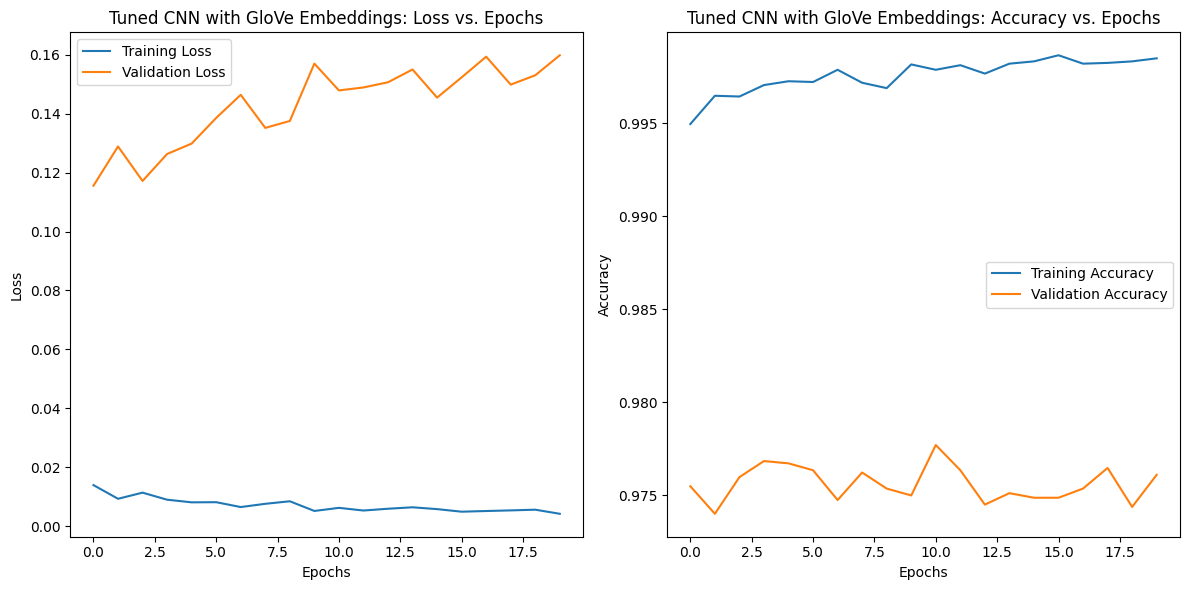

In [382]:
plot_model_performance(cnn_best_model_history, "Tuned CNN with GloVe Embeddings")

**Loss vs. Epochs**:
- Training Loss: Consistently remains low, demonstrating the model's effective learning from the training data.
- Validation Loss: Shows noticeable fluctuations across epochs, indicating potential instability and challenges in generalization to unseen data.

**Accuracy vs. Epochs**:
- Training Accuracy: Achieves consistently high values, reflecting the model's ability to capture patterns in the training dataset.
- Validation Accuracy: Fluctuates significantly, failing to stabilize over epochs, suggesting overfitting or sensitivity to the validation data.

**Summary**:  
The high training accuracy is commendable, but the unstable validation loss and accuracy trends undermine its reliability for deployment. Thus, the plots rating is <span style='color:green'>**"Good"**</span>, acknowledging its strong training performance while highlighting its validation challenges.

### 4.5 CNN + LSTM with GloVe Embeddings

In [383]:
print("Tuning CNN + LSTM with GloVe Embeddings...")
cnn_lstm_best_model, cnn_lstm_best_hps = tune_or_load_model('cnn_lstm')

Tuning CNN + LSTM with GloVe Embeddings...
Best model loaded from tuned_models\cnn_lstm_best_model.keras
Best hyperparameters loaded from tuned_models\cnn_lstm_best_hps.json


C:\Users\WeiZhenLim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 15 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [384]:
print(cnn_lstm_best_hps)

{'kernel_regularizer': 'l2', 'filters': 160, 'kernel_size': 5, 'dropout': 0.30000000000000004, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.0017503179849257852, 'l1_value': 0.0063504831975336115, 'l2_value': 4.6335592241813245e-05, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0019'}


In [385]:
cnn_lstm_best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_input (InputLayer)    │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 300)       │    48,022,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 296, 160)       │       240,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 296, 160)       │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 160)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,833,768 (186.29 MB)

 Trainable params: 405,345 (1.55 MB)

 Non-trainable params: 48,023,076 (183.19 MB)

 Optimizer params: 405,347 (1.55 MB)

In [386]:
cnn_lstm_best_model_metrics = evaluate_model(cnn_lstm_best_model, X_val_padded, y_val)
print("CNN + LSTM with GloVe Embeddings Performance:")
print(cnn_lstm_best_model_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
CNN + LSTM with GloVe Embeddings Performance:
{'accuracy': 0.9730195885179254, 'precision': 0.9773840055957099, 'recall': 0.9717199814557256, 'f1_score': 0.9745437638033244}


In [387]:
cnn_lstm_best_model_history = retrain_best_model_and_save_history(
    cnn_lstm_best_model, cnn_lstm_best_hps, 'tuned_cnn_lstm', 
    X_train_padded, y_train, X_val_padded, y_val)

History file 'tuned_models\tuned_cnn_lstm_history.json' found. Loading existing training history...
Loaded history: ['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall']


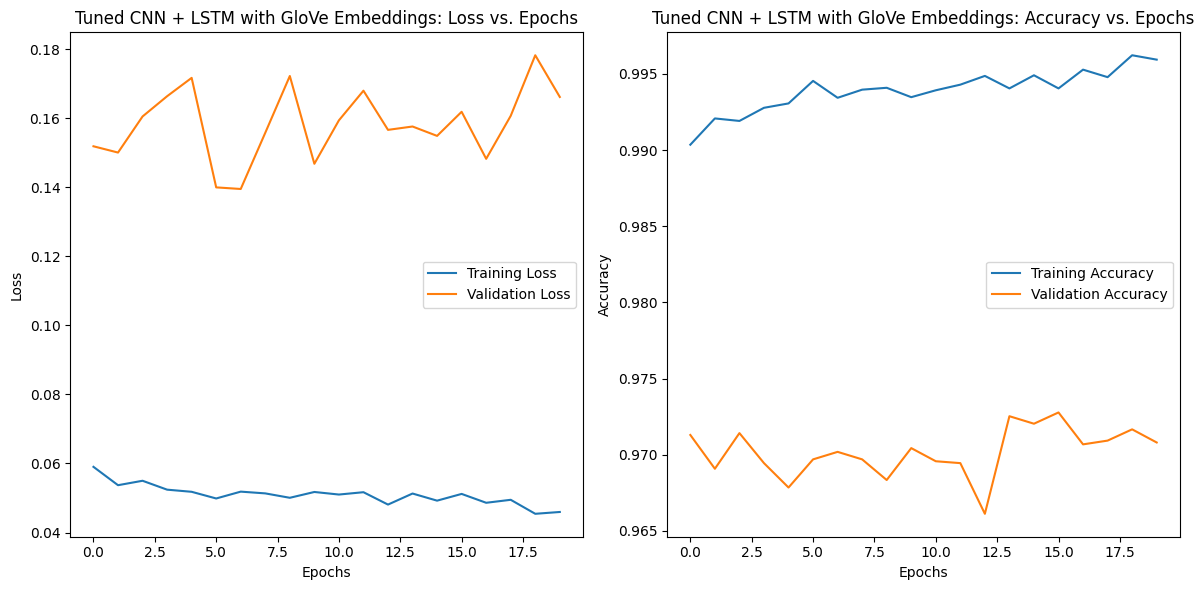

In [388]:
plot_model_performance(cnn_lstm_best_model_history, "Tuned CNN + LSTM with GloVe Embeddings")

**Loss vs. Epochs**:
- Training Loss: The training loss is low and remains consistent across epochs, demonstrating effective learning from the training dataset.
- Validation Loss: The validation loss shows noticeable fluctuations, indicating potential challenges in the model's generalization to unseen data.

**Accuracy vs. Epochs**:
- Training Accuracy: The training accuracy is consistently high, indicating robust pattern recognition on the training data.
- Validation Accuracy: The validation accuracy fluctuates significantly and does not show a clear trend of improvement, suggesting overfitting or sensitivity to validation data variations.

**Summary**:  
While the training performance is strong, the unstable validation metrics reveal limitations in generalization. The plots rating is <span style='color:green'> **"Good"** </span>, acknowledging the effective training performance but highlighting the model's validation issues.

## Section 5: Final Model Evaluation

In this section, the best hyperparameter-tuned models from Section 4 are evaluated on the unseen test set to assess their final performance. This evaluation provides a comprehensive measure of each model's generalization ability, ensuring the selected hyperparameters effectively enhance the model's performance on previously unseen data. Metrics such as accuracy, precision, recall, and F1-score are used to compare the models and identify the most effective architecture for the task. These results highlight the model's suitability for real-world applications and its ability to handle diverse data scenarios.

### 5.1 Bi-LSTM with GloVe Embeddings (Attention Mechanism)

In [389]:
bilstm_attention_final_model_metrics = evaluate_model(bilstm_attention_best_model, X_test_padded, y_test)

print("Bi-LSTM with GloVe Embeddings (Attention Mechanism) Performance:")

print(bilstm_attention_final_model_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step
Bi-LSTM with GloVe Embeddings (Attention Mechanism) Performance:
{'accuracy': 0.9806578785265492, 'precision': 0.98300803673938, 'recall': 0.980980751604033, 'f1_score': 0.9819933478609932}


In [390]:
bilstm_attention_final_model_history = retrain_best_model_and_save_history(
    bilstm_attention_best_model, bilstm_attention_best_hps, 'final_bilstm_attention', 
    X_train_padded, y_train, X_test_padded, y_test)

History file 'tuned_models\final_bilstm_attention_history.json' found. Loading existing training history...
Loaded history: ['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall']


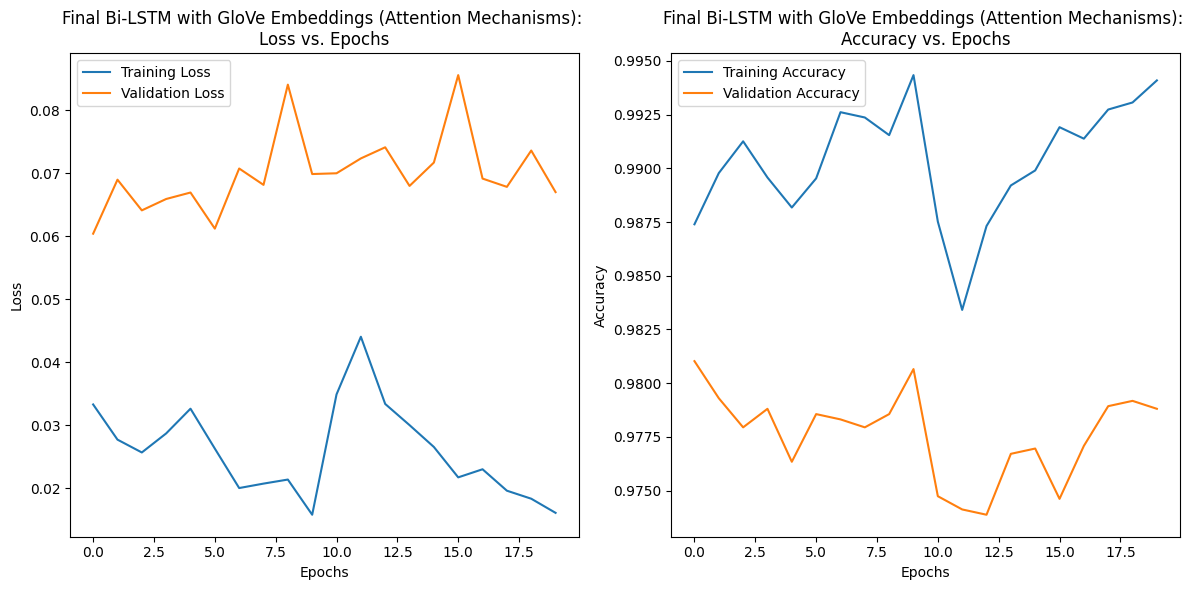

In [391]:
plot_model_performance(bilstm_attention_final_model_history, "Final Bi-LSTM with GloVe Embeddings (Attention Mechanisms)", True)

**Loss vs. Epochs**:
- Training loss steadily decreases, showing effective learning during training.
- Validation loss shows minor fluctuations, suggesting that the model is learning without significant overfitting, though there is some instability.

**Accuracy vs. Epochs**:
- Training accuracy improves consistently, nearing 99.5%, indicating that the model has high predictive power on the training set.
- Validation accuracy fluctuates, stabilizing around 98%, which aligns with the validation loss trend and demonstrates robust generalization with slight variance.

**Summary**:  
The model exhibits strong generalization with high accuracy and controlled loss, making it a top-performing architecture.

In [392]:
bilstm_attention_final_model_plot_rating = 'Very Good'

### 5.2 Bi-LSTM with GloVe Embeddings

In [393]:
bilstm_final_model_metrics = evaluate_model(bilstm_best_model, X_test_padded, y_test)

print("Bi-LSTM with GloVe Embeddings Performance:")

print(bilstm_final_model_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step
Bi-LSTM with GloVe Embeddings Performance:
{'accuracy': 0.980165085622767, 'precision': 0.9863457532978477, 'recall': 0.9766269477543538, 'f1_score': 0.9814622913068509}


In [394]:
bilstm_final_model_history = retrain_best_model_and_save_history(
    bilstm_best_model, bilstm_best_hps, 'final_bilstm', 
    X_train_padded, y_train, X_test_padded, y_test
)

History file 'tuned_models\final_bilstm_history.json' found. Loading existing training history...
Loaded history: ['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall']


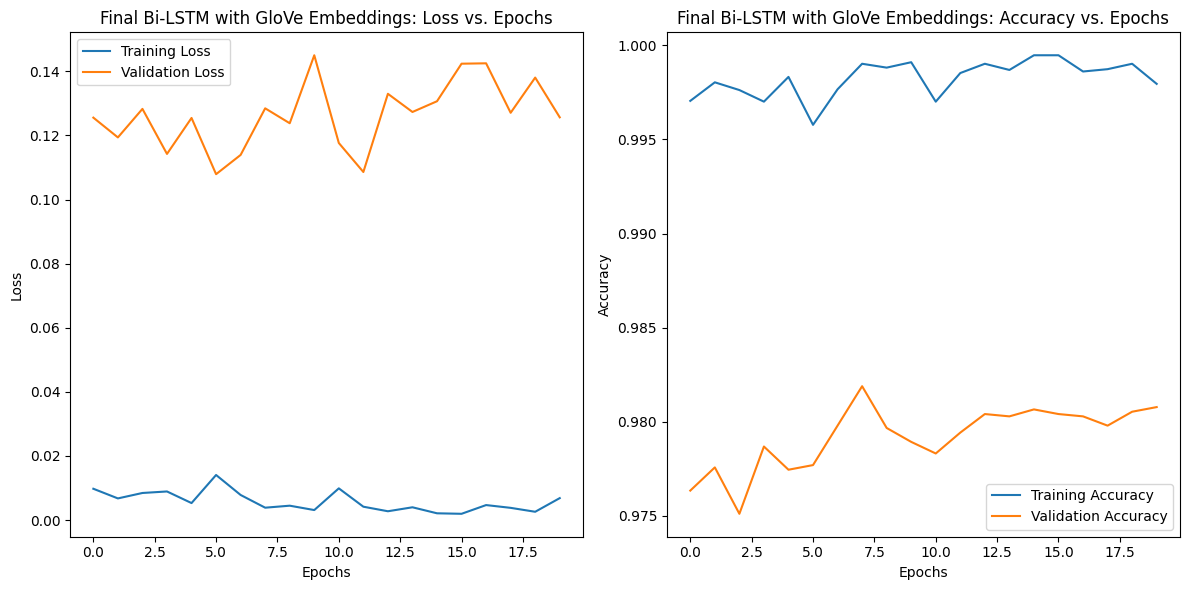

In [395]:
plot_model_performance(bilstm_final_model_history, "Final Bi-LSTM with GloVe Embeddings")

**Loss vs. Epochs**:
- Training loss remains consistently low and stable, indicating effective optimization of the model during training.
- Validation loss fluctuates moderately but does not show signs of significant overfitting, suggesting good generalization.

**Accuracy vs. Epochs**:
- Training accuracy stabilizes at a very high level, nearly 99.8%, showing excellent learning capability.
- Validation accuracy exhibits some variability but generally trends upwards, stabilizing close to 98%, which aligns with strong generalization performance.

**Summary**:  
This model achieves excellent training and validation metrics, with minimal overfitting and high predictive power, making it a highly reliable choice for the final evaluation.

In [396]:
bilstm_final_model_plot_rating = 'Very Good'

### 5.3 LSTM with GloVe Embeddings

In [397]:
lstm_final_model_metrics = evaluate_model(lstm_best_model, X_test_padded, y_test)

print("LSTM with GloVe Embeddings Performance:")

print(lstm_final_model_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 64s 252ms/step
LSTM with GloVe Embeddings Performance:
{'accuracy': 0.9811506714303314, 'precision': 0.9881752840250406, 'recall': 0.9766269477543538, 'f1_score': 0.9823671775959433}


In [398]:
lstm_final_model_history = retrain_best_model_and_save_history(
    lstm_best_model, lstm_best_hps, 'final_lstm', 
    X_train_padded, y_train, X_test_padded, y_test
)

History file 'tuned_models\final_lstm_history.json' found. Loading existing training history...
Loaded history: ['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall']


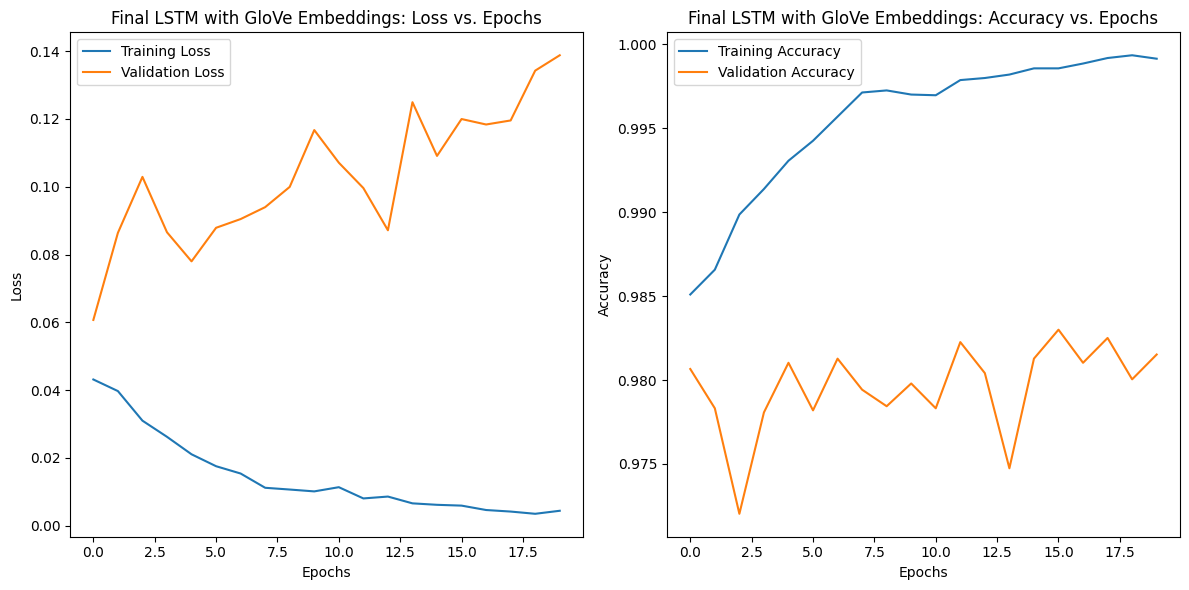

In [399]:
plot_model_performance(lstm_final_model_history, "Final LSTM with GloVe Embeddings")

**Loss vs. Epochs**:
- Training loss consistently decreases, indicating effective optimization during training.
- Validation loss fluctuates and increases in later epochs, suggesting potential overfitting.

**Accuracy vs. Epochs**:
- Training accuracy steadily improves, reaching very high levels (above 99.5%), demonstrating the model's strong learning ability.
- Validation accuracy exhibits significant variability, with notable dips, indicating instability and potential overfitting.

**Summary**:  
While the model demonstrates strong training performance, the fluctuations in validation metrics indicate challenges with generalization. Further fine-tuning or regularization might help mitigate overfitting and improve stability.

In [400]:
lstm_final_model_plot_rating = 'Good'

### 5.4 CNN with GloVe Embeddings

In [401]:
cnn_final_model_metrics = evaluate_model(cnn_best_model, X_test_padded, y_test)

print("CNN with GloVe Embeddings Performance:")

print(cnn_final_model_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step
CNN with GloVe Embeddings Performance:
{'accuracy': 0.9793026980411482, 'precision': 0.9822988505747127, 'recall': 0.979147571035747, 'f1_score': 0.9807206793665366}


In [402]:
cnn_final_model_history = retrain_best_model_and_save_history(
    cnn_best_model, cnn_best_hps, 'final_cnn', 
    X_train_padded, y_train, X_test_padded, y_test
)

History file 'tuned_models\final_cnn_history.json' found. Loading existing training history...
Loaded history: ['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall']


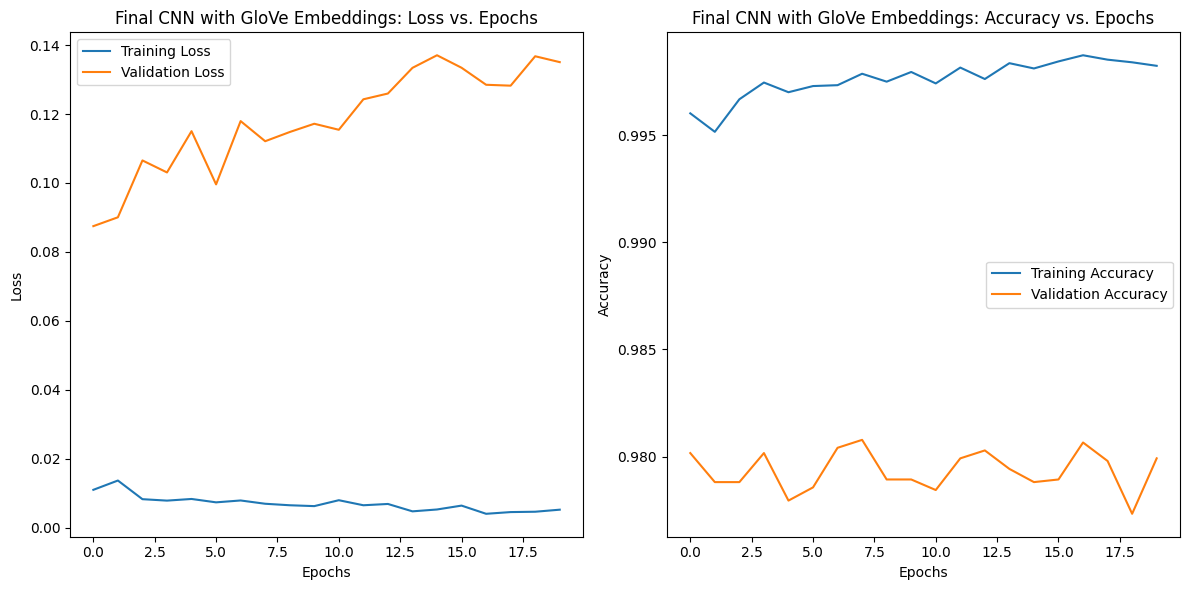

In [403]:
plot_model_performance(cnn_final_model_history, "Final CNN with GloVe Embeddings")

**Loss vs. Epochs**:
- Training loss remains low and stable, indicating a well-optimized model during training.
- Validation loss increases over epochs, showing signs of overfitting as the model struggles to generalize to the validation set.

**Accuracy vs. Epochs**:
- Training accuracy is consistently high, exceeding 99.5%, indicating strong performance during training.
- Validation accuracy fluctuates significantly, with no consistent improvement, indicating instability and overfitting.

**Summary**:  
While the model performs well on the training set, its fluctuating validation performance suggests that it struggles with generalization. Further adjustments, such as adding regularization techniques or early stopping, might improve validation stability.

In [404]:
cnn_final_model_plot_rating = 'Good'

### 5.5 CNN + LSTM with GloVe Embeddings

In [405]:
cnn_lstm_final_model_metrics = evaluate_model(cnn_lstm_best_model, X_test_padded, y_test)

print("CNN + LSTM with GloVe Embeddings Performance:")

print(cnn_lstm_final_model_metrics)

254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
CNN + LSTM with GloVe Embeddings Performance:
{'accuracy': 0.9757299494887274, 'precision': 0.9817341040462427, 'recall': 0.9729605866177818, 'f1_score': 0.9773276556565773}


In [406]:
cnn_lstm_final_model_history = retrain_best_model_and_save_history(
    cnn_lstm_best_model, cnn_lstm_best_hps, 'final_cnn_lstm', 
    X_train_padded, y_train, X_test_padded, y_test
)

History file 'tuned_models\final_cnn_lstm_history.json' found. Loading existing training history...
Loaded history: ['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall']


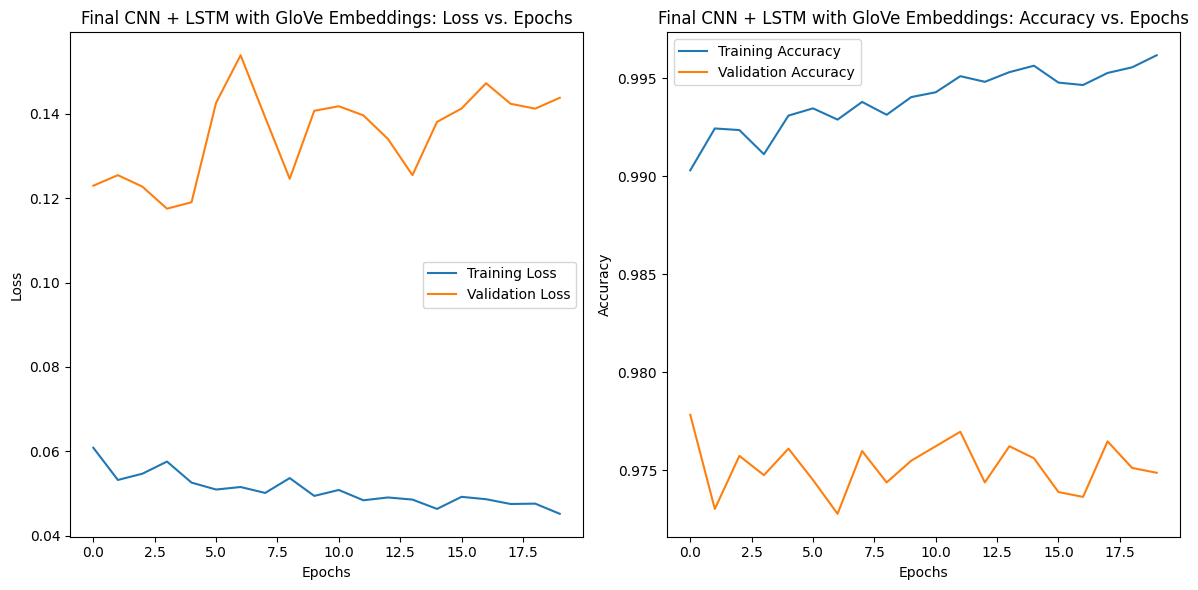

In [407]:
plot_model_performance(cnn_lstm_final_model_history, "Final CNN + LSTM with GloVe Embeddings")

**Loss vs. Epochs**:
- Training loss is consistently low and decreases slightly over epochs, demonstrating effective learning during training.
- Validation loss fluctuates significantly and does not show consistent improvement, which indicates potential overfitting and challenges with generalization.

**Accuracy vs. Epochs**:
- Training accuracy is high, stabilizing above 99%, which reflects excellent performance on the training set.
- Validation accuracy exhibits fluctuations throughout the epochs, with no clear upward trend, suggesting instability and overfitting.

**Summary**:  
While the model excels on the training set, the validation performance instability indicates room for improvement in generalization. Additional regularization techniques or adjustments to the architecture may help address the overfitting.

In [408]:
cnn_lstm_final_model_plot_rating = 'Good'

### 5.6 Conclusion

In [409]:
# Complie the results
compile_metrics([
    {**cnn_final_model_metrics, 'Model': 'CNN with GloVe'},
    {**lstm_final_model_metrics, 'Model': 'LSTM with GloVe'},
    {**bilstm_final_model_metrics, 'Model': 'Bi-LSTM with GloVe'},
    {**cnn_lstm_final_model_metrics, 'Model': 'CNN + LSTM with GloVe'},
    {**bilstm_attention_final_model_metrics, 'Model': 'Bi-LSTM with GloVe (Attention)'}],
    [cnn_final_model_plot_rating, 
     lstm_final_model_plot_rating, 
     bilstm_final_model_plot_rating,
     cnn_lstm_final_model_plot_rating,
     bilstm_attention_final_model_plot_rating]
)

,accuracy,precision,recall,f1_score,Model,Plots Rating
1,0.981151,0.988175,0.976627,0.982367,LSTM with GloVe,Good
4,0.980658,0.983008,0.980981,0.981993,Bi-LSTM with GloVe (Attention),Very Good
2,0.980165,0.986346,0.976627,0.981462,Bi-LSTM with GloVe,Very Good
0,0.979303,0.982299,0.979148,0.980721,CNN with GloVe,Good
3,0.975730,0.981734,0.972961,0.977328,CNN + LSTM with GloVe,Good
